# UNIVARIATE FORECASTING

In [1]:
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

It is important and useful to test *simple forecast strategies* prior to testing more complex models. Simple forecast strategies are those that assume little or nothing about the nature of the forecast problem and are fast to implement and calculate. The results can be used as a *baseline in performance* and used as a *point of a comparison*. If a model can perform better than the performance of a simple forecast strategy, then it can be said to be skillful. 

Machine learning and deep learning methods can achieve impressive results on challenging time-series forecasting problems. Nevertheless, there are many forecasting problems where classical (statistical) methods readily outperform more sophisticated methods. Therefore, it is important to both understand how classical time-series forecasting methods work and to evaluate them prior to exploring more advanced methods.

The paper **"Evaluation of statistical and machine learning models for time series prediction: Identifying the state-of-the-art and the best conditions for the use of each model"** provides a detailed guide to popular forecasting methods, comparing the results obtained from each of them.

An important consideration regarding the search of the best forecast algorithm is the selection of the best techniques for parameter estimation. In fact, one of the main difficulties faced by researchers in the time-series prediction is the search for the best parameter setting to fit a model according to a dataset. Next, we present the main parameter estimation methods for time-series prediction:

- *Holdout validation*: we divide the original dataset into training, validation and test set. The steps of this method are: training the model on the training set; the validation set is then used to optimize the hyperparameters of the models, thus, the validation set is used to tune the various hyperparameters and select the best performing algorithm; finally, test dataset is used to evaluate the final selected model and the error found here is considered as the generalisation error.
- *Cross-validation*: we split the data into 2 datasets: training and test. k-folds cross validation takes a model (and specified hyperparameters) and partitions the training dataset into k equally sized subsets. Then, it does the following k times: (i) Trains the model on k-1 of the subsets; (ii) Evaluates the model accuracy on the subset that wasn’t trained on. It then reports the average error. To do hyperparameter tuning, iterate through a wide range of hyperparameter combinations. Then, choose the set of parameters for which k-folds reports the lowest error. However, be careful to not excessively minimize the k-folds error, since it will often lead to overfitting. Ultimately, we want a measure of how well our final model will generalize. This is why we created the test set at the beginning evaluating the model’s accuracy on this set is a useful estimation of its success.
- *Box-Jenkins method*: we can determine the parameters of an ARIMA/SARIMA models via a search mechanism guided by an information criterion that penalizes the models’ adjustment with many parameters (see paper for more details).

In the current analysis, different estimation methods will be alternated according to the model.

Let's load the time-series of the Adminstratas of the Yemen country (FCS indicator) with which we want to test some forecasting approaches.

# Forecast Food Consumption Score (FCS) time-series of the Yemen country

In [2]:
# Load the time-series data.
df = pd.read_excel("../Data Sources/Food Consumption Score (FCS)/wfp_fcs_yemen.xlsx", index_col = 0, parse_dates = True)
df = df.asfreq("M")
df.columns.name = "AdminStrata"
df.index.name = "Datetime"
df.head()

AdminStrata  FCS_Abyan  FCS_Ad Dali  FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                       
2015-09-30      34.100        57.43     21.22         32.76            32.28   
2015-10-31      40.145        54.33     38.02         46.39            37.67   
2015-11-30      46.190        56.44     27.95         52.56            32.65   
2015-12-31      36.110        53.04     30.60         54.37            25.54   
2016-01-31      43.440        50.44     26.24         55.33            32.19   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2015-09-30         37.97           18.00          34.38      46.82   
2015-10-31         49.74           25.00          34.56      45.05   
2015-11-30         56.74           35.56          39.38      58.51   
2015-12-31         58.22           24.82          34.31      53.84   
2016-01-31         55.17           19.78          29.67      46.88   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah  FCS_Ibb  FCS_Lahj  FCS_Marib  \
Datetime                 ...                                             
2015-09-30        51.76  ...       52.04    48.10     41.31      61.71   
2015-10-31        58.15  ...       54.73    46.12     37.69      49.25   
2015-11-30        55.58  ...       51.95    51.04     30.62      45.39   
2015-12-31        55.84  ...       43.49    47.02     50.17      47.12   
2016-01-31        49.89  ...       52.10    51.67     48.03      45.62   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2015-09-30        62.84   46.230000       38.25            33.43        35.22   
2015-10-31        60.59   44.811429       40.24            36.76        42.42   
2015-11-30        65.15   43.392857       29.66            35.96        42.41   
2015-12-31        67.28   41.974286       50.51            42.51        51.00   
2016-01-31        64.38   40.555714       52.91            38.82        57.95   

AdminStrata  FCS_Taizz  
Datetime                
2015-09-30       55.37  
2015-10-31       57.60  
2015-11-30       59.83  
2015-12-31       55.53  
2016-01-31       62.71  

[5 rows x 21 columns]

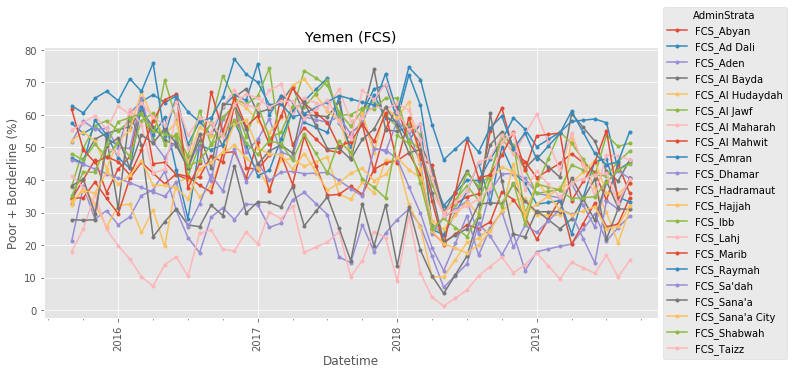

In [3]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
df.plot(ax = f.gca(), style = ".-")
plt.legend(title = df.columns.name, loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Poor + Borderline (%)")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

In [4]:
# Let's define the number of observations we want to predict as test set.
num_test = 4
# Let's define the number of observations to use as validation set.
num_val = 4
# Let's define the number of observations to use during training.
num_train = len(df) - num_val - num_test
# Train.
df_train = df[:num_train]
# Validation.
df_val = df[(-num_val -num_test):-num_test]
# Test.
df_test = df[-num_test:]
dates_to_forecast = df_test.index

print("The number of points used to forecast (training) is:", len(df_train))
print("The number of points used for validating the model:", len(df_val))
print("The number of points to use for testing the forecast is:", len(df_test))

The number of points used to forecast (training) is: 41
The number of points used for validating the model: 4
The number of points to use for testing the forecast is: 4


In [5]:
# Define the dictionary where save the results of all the forecast methods.
df_results = pd.DataFrame([], index = df.columns)
results_forecast = dict()

# Parametric methods

The statistical methods require a priori knowledge about the data distribution to build predictive models. This assumption makes the model depends on a set of parameters, which must be determined to optimize the prediction results.

### Index:

[1. Naive Forecast](#1.-Naive-Forecast)

[2. Simple Moving Average Forecast](#2.-Simple-Moving-Average-Forecast)

[3. Simple Exponential Smoothing Forecast](#3.-Simple-Exponential-Smoothing-Forecast)

[4. Holt's Exponential Smoothing Forecast](#4.-Holt's-Exponential-Smoothing-Forecast)

[5. Holt-Winters' Seasonal Exponential Smoothing Forecast](#5.-Holt-Winters'-Seasonal-Exponential-Smoothing-Forecast)

[6. Autoregression Forecast](#6.-Autoregression-Forecast)

[7. Moving Average Forecast](#7.-Moving-Average-Forecast)

[8. Autoregressive Integrated Moving Average Forecast](#8.-Autoregressive-Integrated-Moving-Average-Forecast)

[9. Seasonal Autoregressive Integrated Moving Average Forecast](#9.-Seasonal-Autoregressive-Integrated-Moving-Average-Forecast)

## 1. Naive Forecast

Naive model is a persistence model that simply uses the last observation of the corresponding time-series as prediction of the next time step. Given a time-series $X = \{x_1, x_2, ..., x_m\}$, let's suppose to want to predict the next $x_{m + 1}$ value.
The Naive model chooses as prediction:

$$\hat{y} = x_m$$

where $\hat{y}$ is the prediction for the $x_{m + 1}$ value.

This simple approach can be adjusted slightly for seasonal data. In this case, the observation at the same time in the previous cycle may be persisted instead. This can be further generalized to testing each possible offset into the historical data that could be used to persist a value for a forecast. For example, setting the offset not to the last observation $x_t$ but to n-ultimate observation $x_{m - n}$:

$$\hat{y} = x_{m - n}$$

Let's search for the best $n$ parameter for each AdminStrata using a grid search and exploiting the **Holdout estimation**.

In [6]:
# Set the parameter n. All the integer in the range of this number are used during the validation step to establish the best one for each adminstrata.
ns = np.arange(0, len(df_train) + 1, 1)

In [7]:
def evaluate_naive_forecast(time_series, n):
    for i in range(num_val):
        # Make predictions.
        y_hat = time_series[-n] 
        y_hat = pd.Series(y_hat, index = [df_val.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate the validation error.
    y_hats = time_series[-num_val:]
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, n

In [8]:
def naive_forecast(time_series, ns):    
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_n = float("inf"), None
    for n in ns:
        try:
            error_val, n = evaluate_naive_forecast(time_series, n)
            if error_val < best_score:
                best_score, best_n = error_val, n 
        except:
            continue
        
    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    for i in range(num_test):
        # Make prediction.
        y_hat = time_series[-best_n] 
        y_hat = pd.Series(y_hat, index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]           
    
    return (best_n), y_hats

In [9]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(naive_forecast, args = [ns])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.08it/s]


In [10]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali  FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                       
2019-06-30       63.22        57.43     21.22         49.70            46.67   
2019-07-31       43.80        57.43     21.22         43.61            43.72   
2019-08-31       43.22        57.43     21.22         47.26            37.26   
2019-09-30       47.62        57.43     21.22         44.05            46.20   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30         58.06          13.900          36.37     34.645   
2019-07-31         60.38          17.590          33.98     34.645   
2019-08-31         52.72          13.605          28.64     34.645   
2019-09-30         70.74           9.620          21.72     34.645   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah  FCS_Ibb  FCS_Lahj  FCS_Marib  \
Datetime                 ...                                             
2019-06-30         32.2  ...      29.830    44.62    54.120      49.17   
2019-07-31         32.2  ...      32.470    43.08    60.270      58.11   
2019-08-31         32.2  ...      35.085    44.62    51.635      64.70   
2019-09-30         32.2  ...      37.700    43.08    43.000      66.37   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30       54.570       29.45       30.21            33.43        35.22   
2019-07-31       46.380       21.96       30.25            33.43        35.22   
2019-08-31       50.405       29.45       30.29            33.43        35.22   
2019-09-30       54.430       21.96       40.73            33.43        35.22   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30      39.200  
2019-07-31      40.375  
2019-08-31      39.200  
2019-09-30      40.375  

[4 rows x 21 columns]

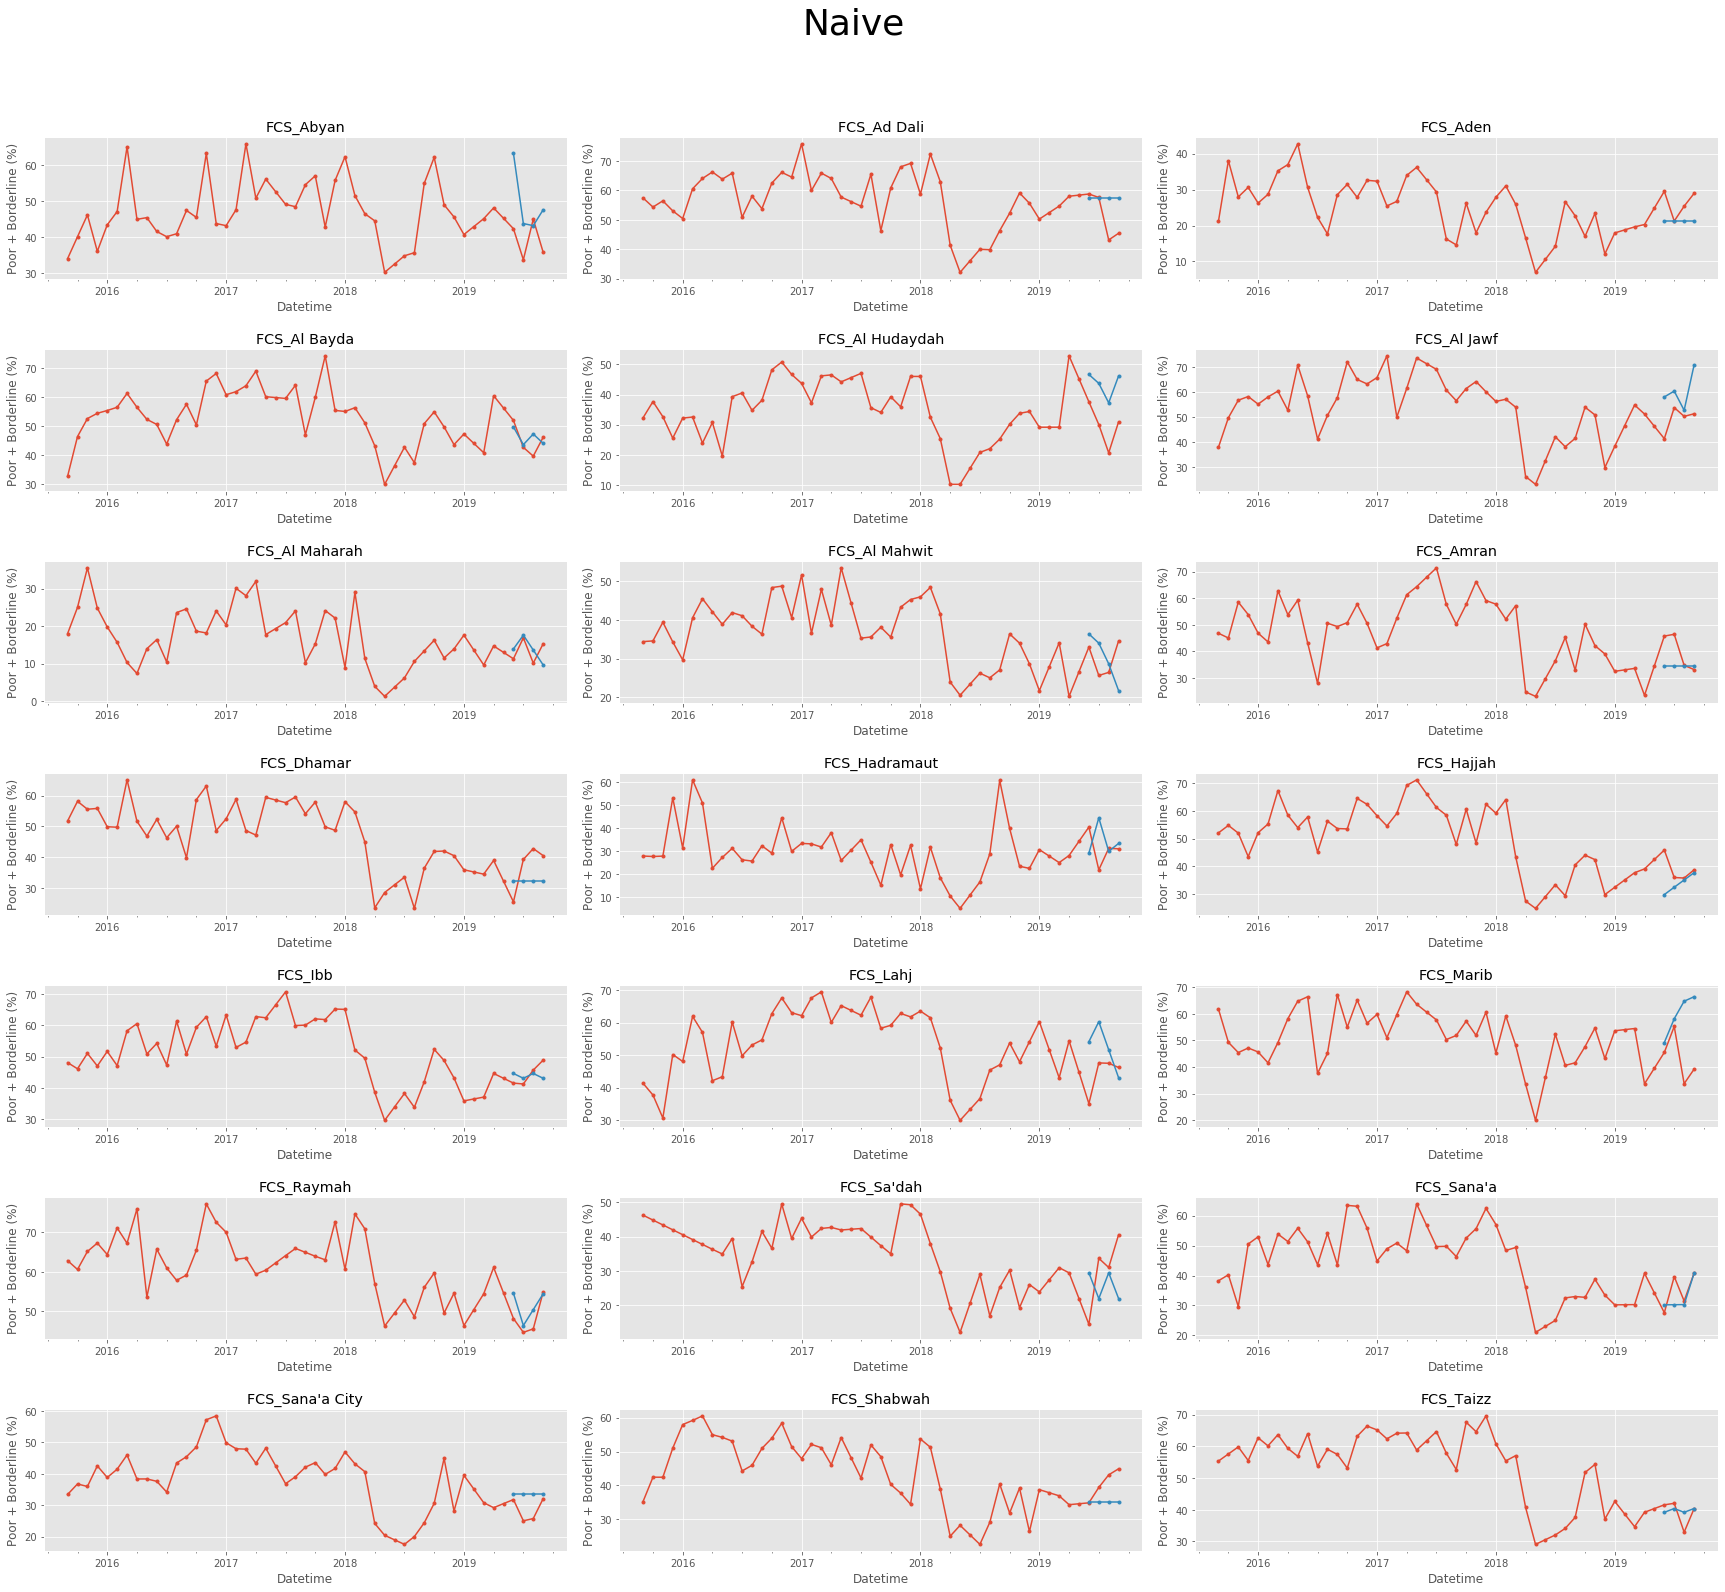

In [11]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Naive", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [12]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["Naive"] = err_test, err_time
df_results["Naive"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 95.6412113095238


## 2. Simple Moving Average Forecast

The SMA model of order $n$, SMA($n$), is a simple technique that performs an arithmetic average of the last $n$ values of time-series to predict the next value. Assuming for example that given a time-series $X = \{x_1, x_2, ..., x_m\}$ and $n = 3$:

$$\hat{y} = \frac{x_{m - 2} + x_{m - 1} + x_m}{3}$$

where $\hat{y}$ is the prediction for the $x_{m + 1}$ value. Let's search for the best $n$ parameter (previous lags for the Avergae model, $x_{m - n}$) for each AdminStrata using a grid search on the validation set. The higher the value of $n$, the more uniform (smoothed) will be the predicted data behavior. The drawbacks of the SMA model are their low accuracy to deal with trend and seasonality. Since the prediction of the next value always involves the addition of new data and the discard of the previous one. Furthermore, the weights assigned to the $n$ observations are typically all equal. Therefore, there is no emphasis on the most recent observations.

Let's search for the best $n$ parameter for each AdminStrata using a grid search and exploiting the **Holdout estimation**.

In [13]:
# Set the parameter n. All the integer in the range of this number are used during the validation step to establish the best one for each adminstrata.
ns = np.arange(0, len(df_train) + 1, 1)

In [14]:
def evaluate_average_forecast(time_series, n):
    for i in range(num_val):
        # Make predictions.
        y_hat = np.mean(time_series[-n:])
        y_hat = pd.Series(y_hat, index = [df_val.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate the validation error.
    y_hats = time_series[-num_val:]
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, n

In [15]:
def average_forecast(time_series, ns):   
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_n = float("inf"), None
    for n in ns:
        try:
            error_val, n = evaluate_average_forecast(time_series, n)
            if error_val < best_score:
                best_score, best_n = error_val, n
        except:
            continue    

    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    for i in range(num_test):
        # Make prediction.
        y_hat = np.mean(time_series[-best_n:])
        y_hat = pd.Series(y_hat, index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]

    return (best_n), y_hats

In [16]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(average_forecast, args = [ns])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.77it/s]


In [17]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   48.216111    56.293548  19.900263     48.862143        35.640000   
2019-07-31   47.467901    55.976566  20.001330     48.742449        35.665882   
2019-08-31   45.838779    55.701294  19.808242     49.475656        35.593702   
2019-09-30   45.487532    55.052949  19.384991     49.792178        35.222635   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     48.489565       12.249722      27.206250     34.645   
2019-07-31     47.594764       11.700262      27.034063     34.645   
2019-08-31     47.021927       11.853610      25.275078     34.645   
2019-09-30     46.607663       10.901033      26.531348     34.645   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30         32.2  ...   37.004286  41.718500  46.010333  43.515667   
2019-07-31         32.2  ...   36.232041  42.510350  45.597689  43.210044   
2019-08-31         32.2  ...   37.146618  42.562385  46.232201  43.856714   
2019-09-30         32.2  ...   37.814706  41.584624  47.321682  45.452495   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    52.936429   24.990938   33.821250        29.016000    34.930278   
2019-07-31    52.644031   24.180996   33.958906        28.239067    34.958627   
2019-08-31    53.100747   23.831058   33.360020        28.507004    33.917995   
2019-09-30    53.354372   24.126124   33.347522        29.044805    32.955106   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   41.033000  
2019-07-31   41.724300  
2019-08-31   42.138730  
2019-09-30   41.176603  

[4 rows x 21 columns]

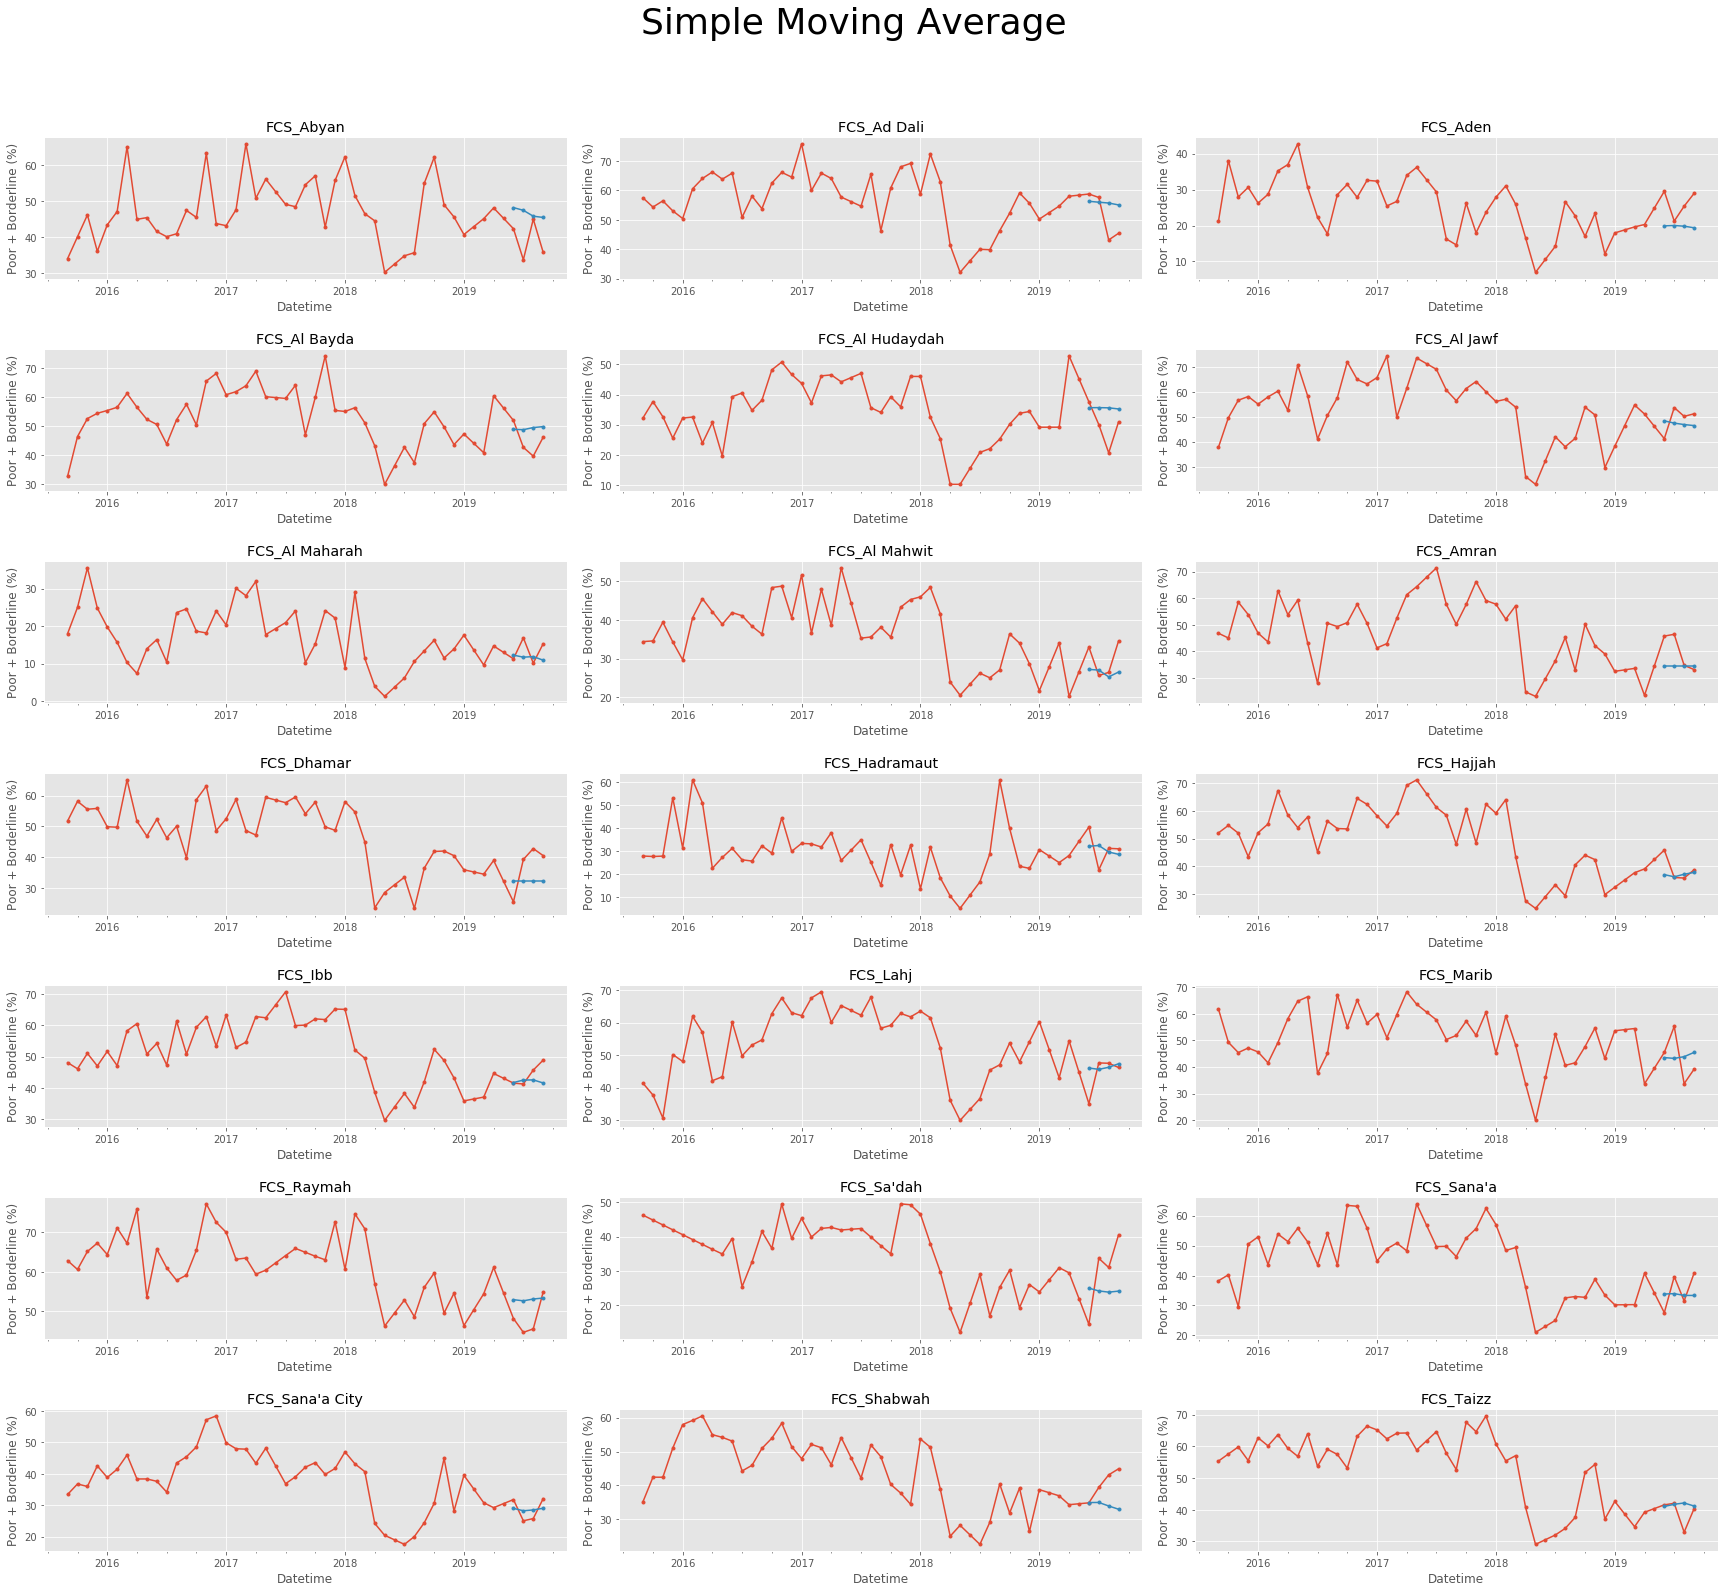

In [18]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Simple Moving Average", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [19]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["Simple Moving Average"] = err_test, err_time
df_results["Simple Moving Average"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 47.077464426995256


## 3. Simple Exponential Smoothing Forecast

Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. The SES method is analogous to MA, except by the fact that each series value receives a different weight. The weights increase exponentially over time so that the most recent observations exert more influence on the calculation of future predictions. Formally, give a time-series $X = \{x_1, x_2, ..., x_m\}$:

$$\hat{y} = \alpha x_m + \alpha(1 - \alpha) x_{m-1} + ... + \alpha(1 - \alpha)^{m-1} x_{1}$$

where $\hat{y}$ is the prediction for the $x_{m + 1}$ value of the time-series. 

It requires a single parameter, $\alpha$, also called the smoothing factor or smoothing coefficient. This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. $\alpha$ is set to a value between $0$ and $1$. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

To avoid an expensive computation that involves all observations for each new estimate, we can reduce the orevious formula in function of the current value of the time-series and the level computed in the previous time:

$$L_t = \alpha x_t + (1 - \alpha) L_{t-1}$$

Usually, at the beginning of the SES prediction process, it is supposed that the first fitted value is equal to the first series value, i.e. $L_1 = x_1$. The exponential smoothing of the last observed value ($z_{m+1} = L_m$) gives the prediction at time $m+1$.

This method does not support an extension to larger horizons.

Let's search for the best $\alpha$ parameter for each AdminStrata using a grid search and exploiting the **Holdout estimation**.

In [20]:
from Modules.Exponentials import SimpleExpSmoothing as SES

In [21]:
alphas = np.arange(0, 1 + 0.25, 0.25)

In [22]:
def evaluate_SES_forecast(time_series, alpha):
    # Make predictions.
    model = SES(time_series, alpha)
    y_hats = model.predict(num_val)
    # Calculate the validation error.
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, alpha

In [23]:
def SES_forecast(time_series, alphas):   
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_alpha = float("inf"), None
    for alpha in alphas:
        try:
            error_val, alpha = evaluate_SES_forecast(time_series, alpha)
            if error_val < best_score:
                best_score, best_alpha = error_val, alpha
        except:
            continue    

    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    # Make predictions.
    model = SES(time_series, best_alpha)
    y_hats = model.predict(num_test)

    return (best_alpha), y_hats

In [24]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(SES_forecast, args = [alphas])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 29.95it/s]


In [25]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali  FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                       
2019-06-30   45.711558        57.43     21.22        56.165            32.28   
2019-07-31   45.711558        57.43     21.22        56.165            32.28   
2019-08-31   45.711558        57.43     21.22        56.165            32.28   
2019-09-30   45.711558        57.43     21.22        56.165            32.28   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     46.749013       13.074673      26.005988     34.645   
2019-07-31     46.749013       13.074673      26.005988     34.645   
2019-08-31     46.749013       13.074673      26.005988     34.645   
2019-09-30     46.749013       13.074673      26.005988     34.645   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30         32.2  ...   38.331431  42.139975  49.181543  44.597948   
2019-07-31         32.2  ...   38.331431  42.139975  49.181543  44.597948   
2019-08-31         32.2  ...   38.331431  42.139975  49.181543  44.597948   
2019-09-30         32.2  ...   38.331431  42.139975  49.181543  44.597948   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30     54.68639   26.045353   34.166942        31.462472    34.678473   
2019-07-31     54.68639   26.045353   34.166942        31.462472    34.678473   
2019-08-31     54.68639   26.045353   34.166942        31.462472    34.678473   
2019-09-30     54.68639   26.045353   34.166942        31.462472    34.678473   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30    39.87327  
2019-07-31    39.87327  
2019-08-31    39.87327  
2019-09-30    39.87327  

[4 rows x 21 columns]

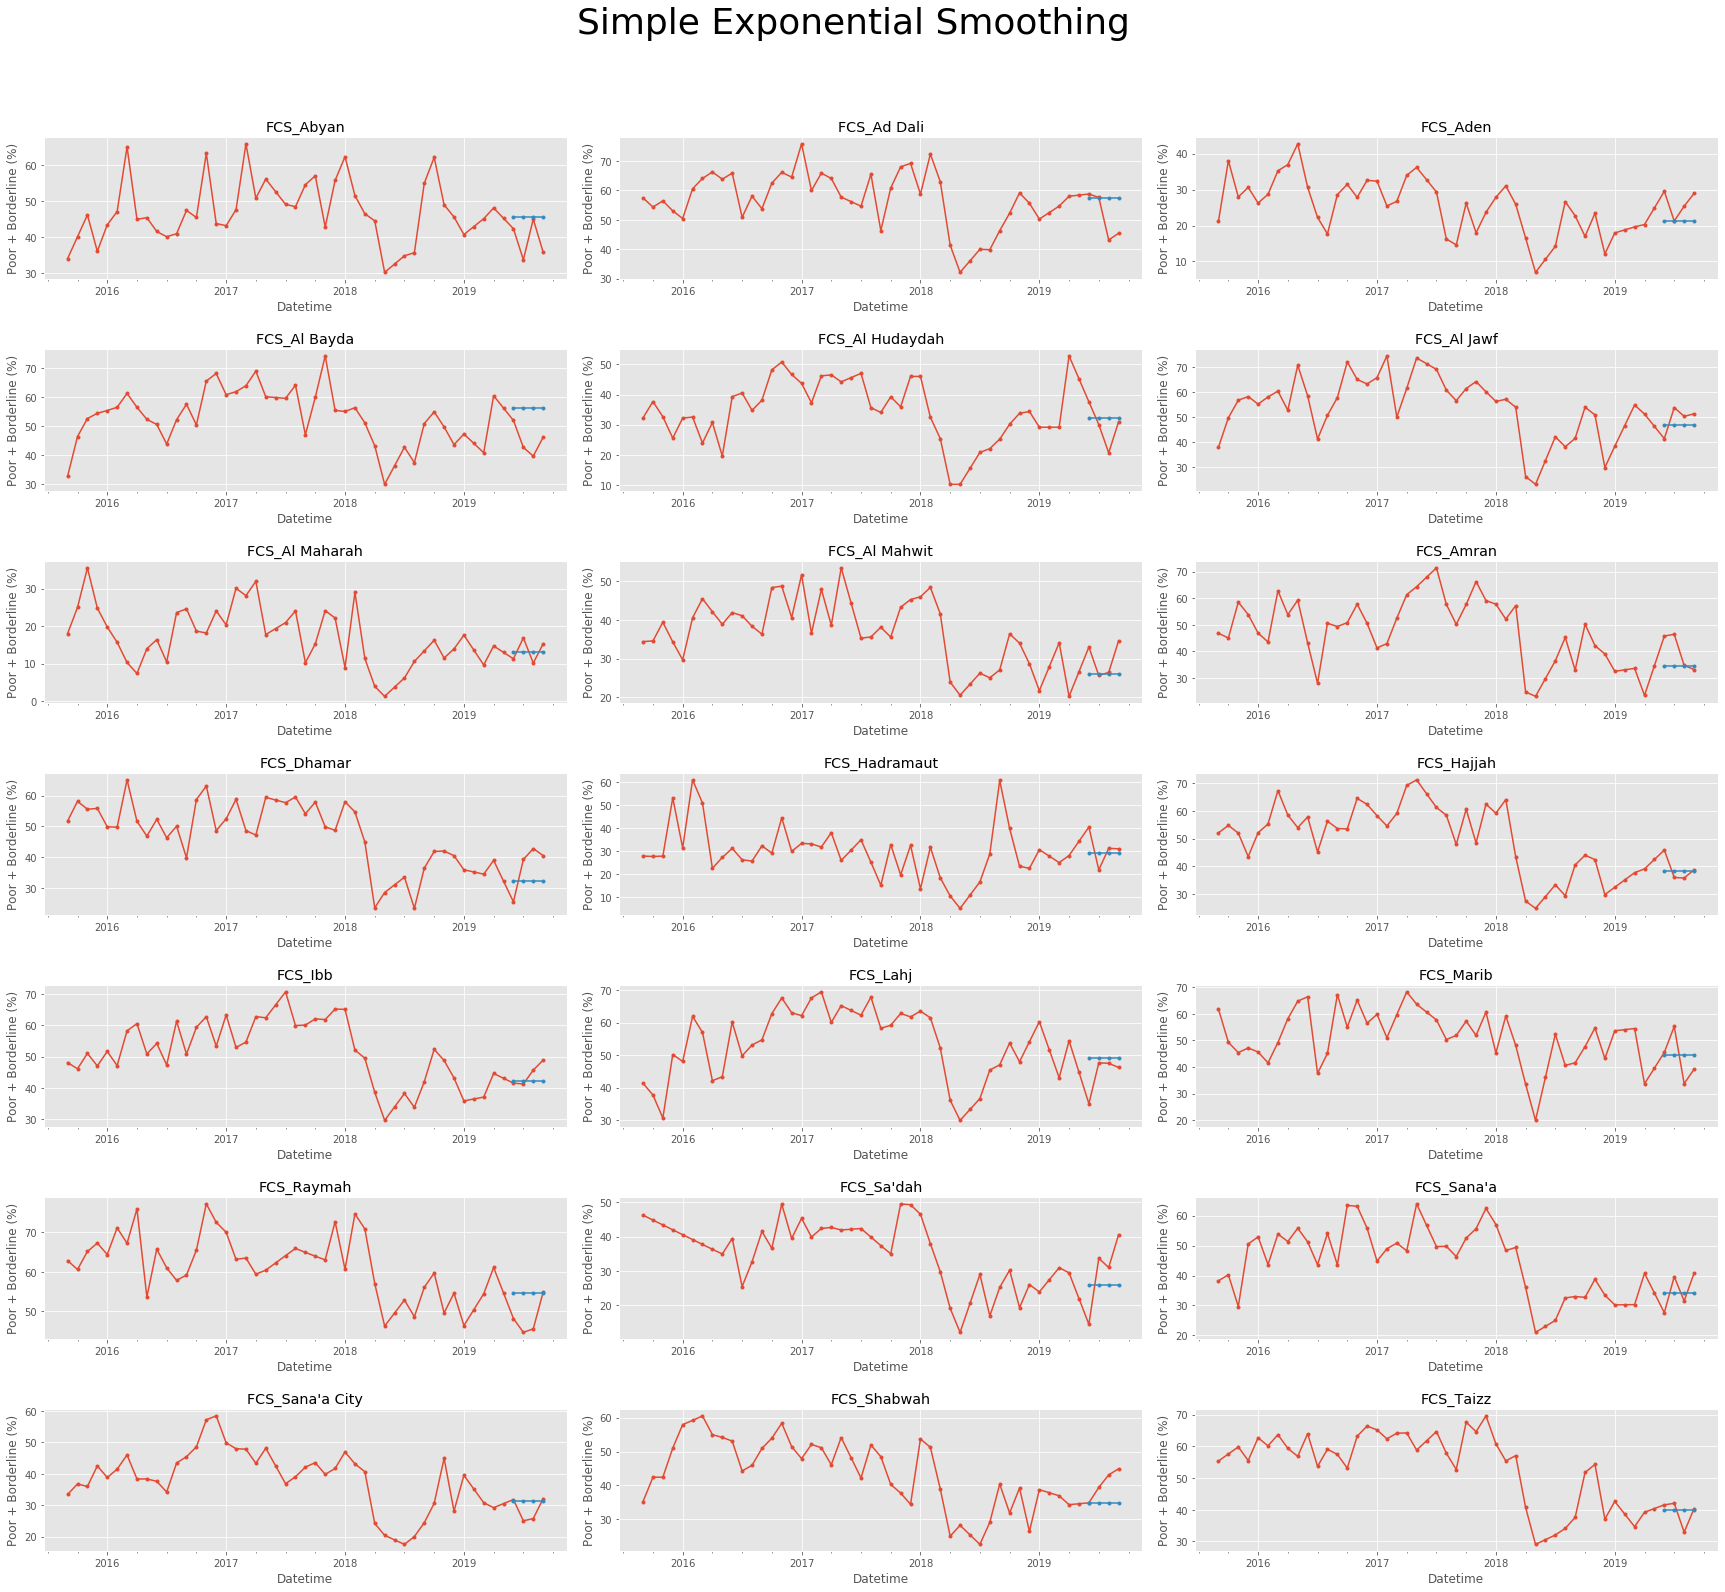

In [26]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Simple Exponential Smoothing", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [27]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["SES"] = err_test, err_time
df_results["SES"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 49.88851382087701


## 4. Holt's Exponential Smoothing Forecast

The SES model when applied to temporal data that present increasing (or decreasing) linear behavior, provides predictions which underestimate (or overestimate) the actual values. To avoid this systematic error, we can make use of methods as Holt’s Exponential Smoothing (HES). The HES model structure is similar to the SES method. However, besides to use the parameter $\alpha$ to soften the level component, the algorithm uses a second smoothing constant $\beta$ for modeling the time-series trend.

$$L_t = \alpha x_t + (1 - \alpha)(L_{t-1} + T_{t-1}) \ \ \ \ \ \ \ \ level$$    

$$T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} \ \ \ \ \ \ \ \ trend$$

$$x_{t + h} = L_t + h T_t$$

where $x_{t + h}$ indicates the prediction value of $x$ at time $t + h$, where $h$ represents the prediction horizons. To implement the HES algorithm recurrence relation, we need to provide its initial values. A widely accepted rule in the literature is to assume $L_1 = x_1$ and $T_1 = x_2 - x_1$.

The smoothing constants values $\alpha$ abd $\beta$ lie in the range $[0, 1]$. 

Side note: Additive vs Multiplicative

Another thing to know about trend is that instead of subtracting  $T_1 = x_2 - x_1$  to estimate its initial value, we could instead divide one by the other thereby getting a ratio. The variant of the method based on subtraction is known as additive, while the one based on division is known as multiplicative. The additive method, is more straightforward to understand. Thus, we will stick with the additive method here.

Let's search for the best $\alpha$ and $\beta$ parameters for each AdminStrata using a grid search and exploiting the **Holdout estimation**.

In [28]:
from Modules.Exponentials import HoltExpSmoothing as HES

In [29]:
alphas = np.arange(0, 1 + 0.25, 0.25)
betas = np.arange(0, 1 + 0.25, 0.25)

In [30]:
def evaluate_HES_forecast(time_series, alpha, beta):
    # Make predictions.
    model = HES(time_series, alpha, beta)
    y_hats = model.predict(num_val)
    # Calculate the validation error.
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, alpha, beta

In [31]:
def HES_forecast(time_series, alphas, betas):   
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_alpha, best_beta = float("inf"), None, None
    orders = list(itertools.product(alphas, betas))
    for order in orders:
        try:
            error_val, alpha, beta = evaluate_HES_forecast(time_series, order[0], order[1])
            if error_val < best_score:
                best_score, best_alpha, best_beta = error_val, alpha, beta
        except:
            continue    
            
    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    # Make predictions.
    model = HES(time_series, best_alpha, best_beta)
    y_hats = model.predict(num_test)

    return (best_alpha, best_beta), y_hats

In [32]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(HES_forecast, args = [alphas, betas])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.60it/s]


In [33]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   46.464394    59.600741  27.564109     56.468155            50.61   
2019-07-31   46.829119    60.917935  30.233218     56.771310            56.00   
2019-08-31   47.193844    62.235128  32.902326     57.074464            61.39   
2019-09-30   47.558569    63.552322  35.571435     57.377619            66.78   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     52.118143       14.754708      26.365988  29.767374   
2019-07-31     52.327286       15.379268      26.545988  29.051337   
2019-08-31     52.536429       16.003828      26.725988  28.335300   
2019-09-30     52.745573       16.628388      26.905988  27.619263   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb  FCS_Lahj  FCS_Marib  \
Datetime                 ...                                               
2019-06-30    30.980318  ...      45.860  42.163868  41.75658  46.964462   
2019-07-31    29.760636  ...      49.255  42.507289  38.13658  47.110741   
2019-08-31    28.540954  ...      52.650  42.850711  34.51658  47.257020   
2019-09-30    27.321272  ...      56.045  43.194133  30.89658  47.403299   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    58.997255   25.673638       36.15        33.598811    33.896650   
2019-07-31    60.588040   24.646759       38.14        34.419496    32.892929   
2019-08-31    62.178826   23.619880       40.13        35.240181    31.889208   
2019-09-30    63.769611   22.593001       42.12        36.060865    30.885487   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   38.282293  
2019-07-31   38.420438  
2019-08-31   38.558582  
2019-09-30   38.696727  

[4 rows x 21 columns]

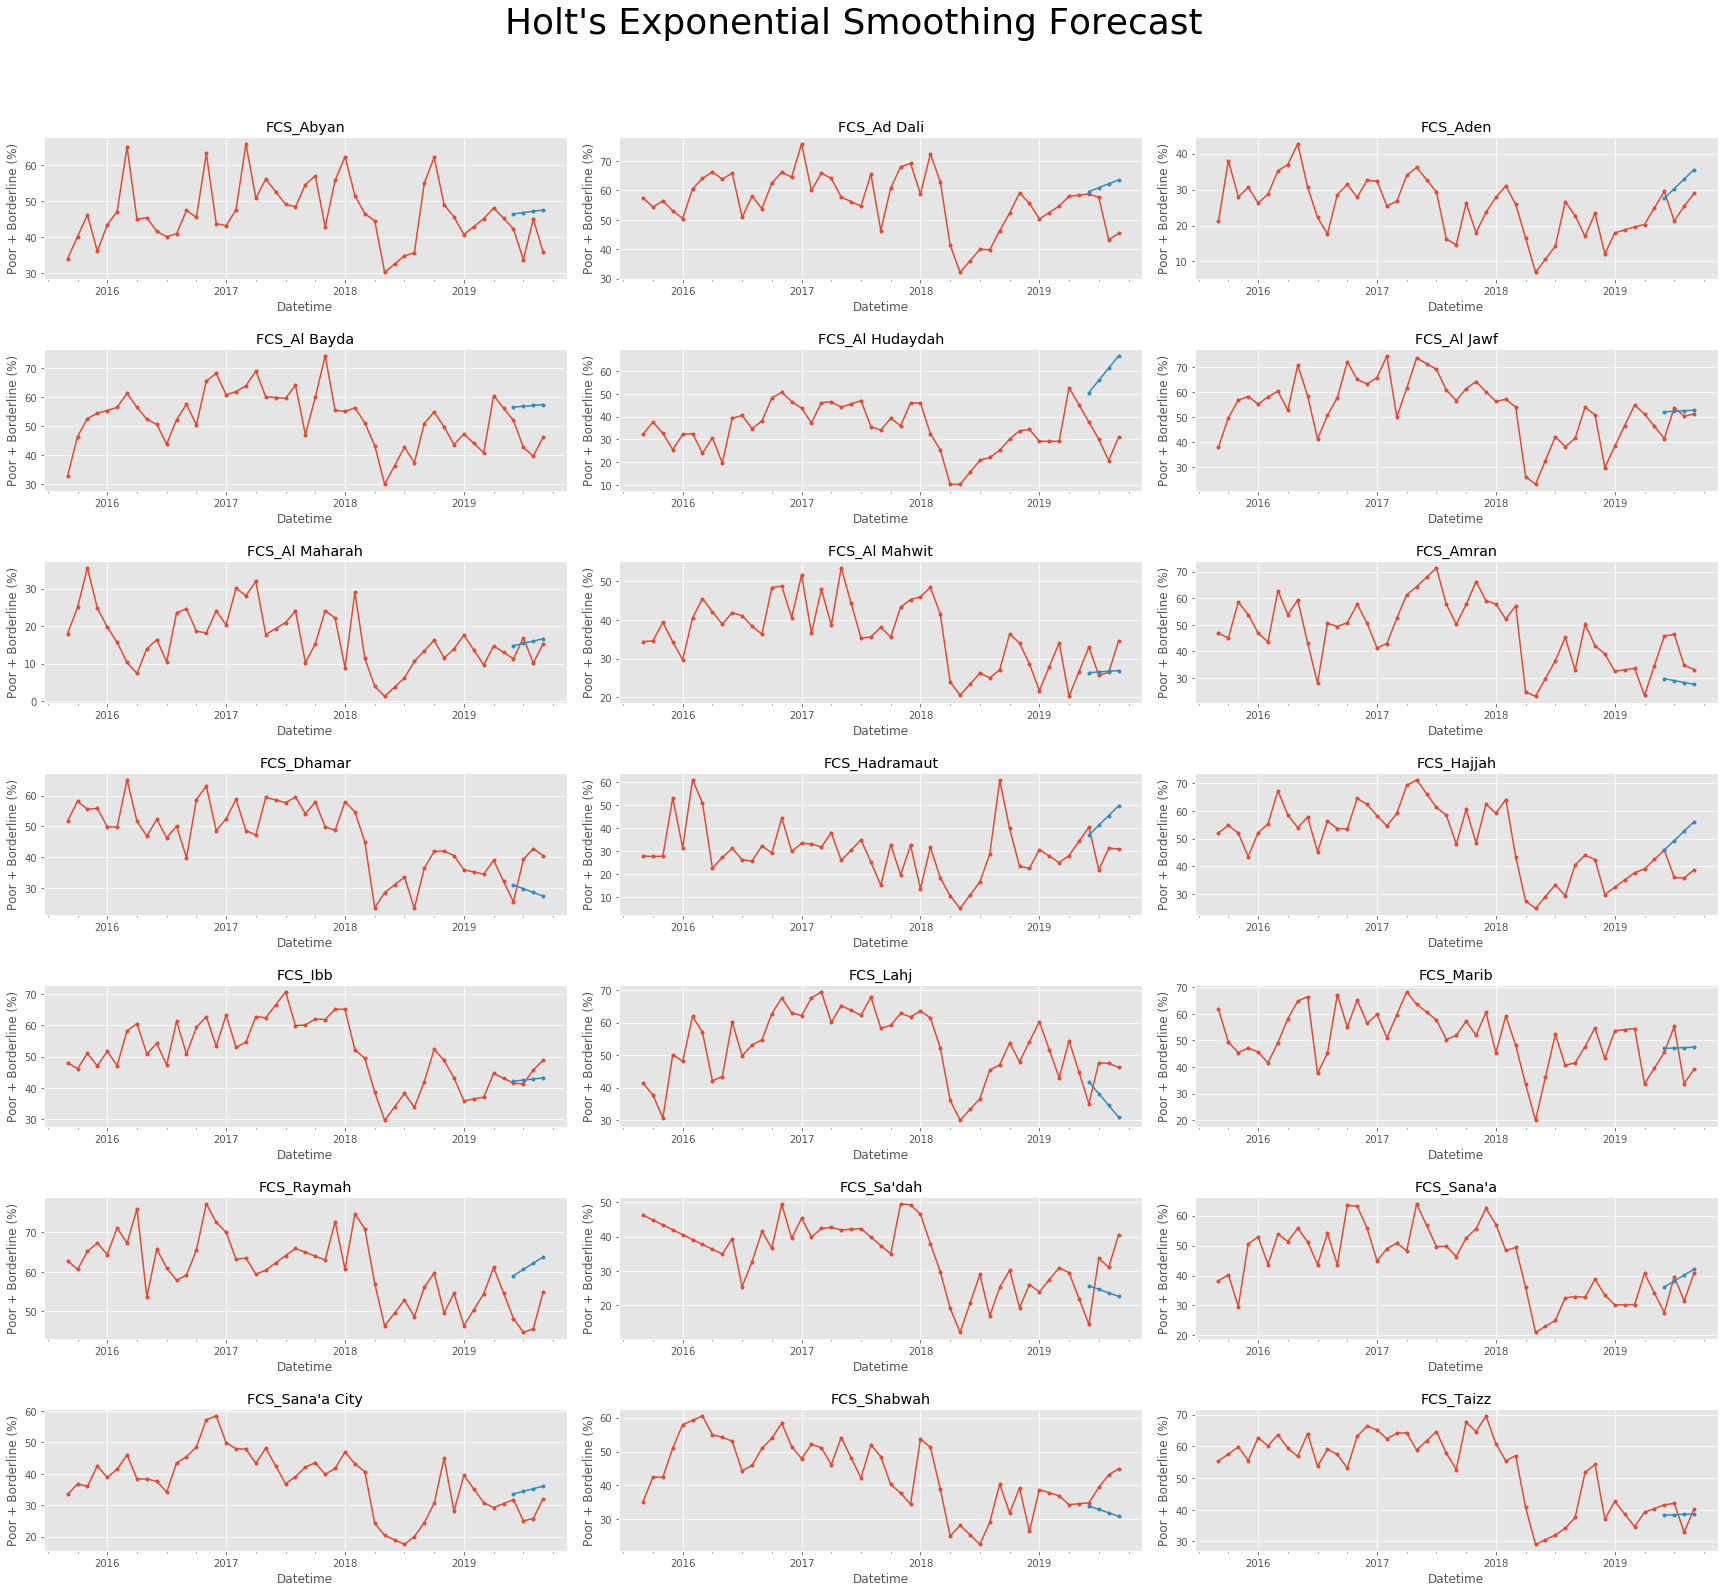

In [34]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Holt's Exponential Smoothing Forecast", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [35]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["HES"] = err_test, err_time
df_results["HES"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 139.71941661824022


## 5. Holt-Winters' Seasonal Exponential Smoothing Forecast

The idea behind triple exponential smoothing (a.k.a Holt-Winters Method) is to apply exponential smoothing to a third component - seasonality, $S$. This means we should not be using this method if our time series is not expected to have seasonality.

Fore more details see related paper and statsmodels api.

Let's search for the best parameters for each AdminStrata using a grid search and exploiting the **Holdout estimation**.

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW

In [38]:
alphas = np.arange(0, 1 + 0.25, 0.25)
betas = np.arange(0, 1 + 0.25, 0.25)
gammas = np.arange(0, 1 + 0.25, 0.25)
seasonals = ["add", "mul"]
ss = np.arange(2, 12 + 2, 2)

In [39]:
def evaluate_HW_forecast(time_series, alpha, beta, gamma, s, seasonal):
    for i in range(num_val):
        # Make predictions.
        model = HW(time_series, trend = "add", seasonal = seasonal, seasonal_periods = s)
        model = model.fit(smoothing_level = alpha, smoothing_slope = beta, smoothing_seasonal = gamma, optimized = False)
        y_hat = model.forecast(1)[0]
        y_hat = pd.Series(y_hat, index = [df_val.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate the validation error.
    y_hats = time_series[-num_val:]
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, alpha, beta, gamma, s, seasonal

In [40]:
def HW_forecast(time_series, alphas, betas, gammas, ss, seasonals):   
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_alpha, best_beta, best_gamma, best_s, best_seasonal = float("inf"), None, None, None, None, None
    orders = list(itertools.product(alphas, betas, gammas, ss, seasonals))
    for order in orders:
        try:
            error_val, alpha, beta, gamma, s, seasonal = evaluate_HW_forecast(time_series, order[0], order[1], order[2], order[3], order[4])
            if error_val < best_score:
                best_score, best_alpha, best_beta, best_gamma, best_s, best_seasonal = error_val, alpha, beta, gamma, s, seasonal
        except:
            continue    
            
    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    for i in range(num_test):
        # Make prediction.
        model = HW(time_series, trend = "add", seasonal = best_seasonal, seasonal_periods = best_s)
        model = model.fit(smoothing_level = best_alpha, smoothing_slope = best_beta, smoothing_seasonal = best_gamma, optimized = False)
        y_hat = model.forecast(1)[0]
        y_hat = pd.Series(y_hat, index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]   

    return (best_alpha, best_beta, best_gamma, best_s, best_seasonal), y_hats

In [41]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(HW_forecast, args = [alphas, betas, gammas, ss, seasonals])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [21:53<00:00, 62.57s/it]


In [42]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata   FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  \
Datetime                                                        
2019-06-30    57.205273    56.823270  19.868984      57.52095   
2019-07-31    75.644563    54.648802  16.026911      75.47190   
2019-08-31    93.200456    60.307968  13.293291      62.34285   
2019-09-30   151.576100    61.530182  13.126581      55.43880   

AdminStrata  FCS_Al Hudaydah  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  \
Datetime                                                                   
2019-06-30         44.114870    25.826286       17.903103      26.806052   
2019-07-31         43.813141    37.614246       21.440730      27.847482   
2019-08-31         45.338780    46.553027       23.598825      27.774996   
2019-09-30         44.189046    54.036988       17.588327      29.597876   

AdminStrata  FCS_Amran  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  \
Datetime                            ...                                     
2019-06-30   49.025732   31.211243  ...   41.849835  40.780816  35.883387   
2019-07-31   49.529410   25.664175  ...   45.177511  48.710277  24.935284   
2019-08-31   40.815487   23.372320  ...   44.781081  55.367845  33.946332   
2019-09-30   23.000262   22.016864  ...   48.234803  49.153882  22.262203   

AdminStrata  FCS_Marib  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  \
Datetime                                                                      
2019-06-30   26.693904   54.929051   29.490615   40.274292        32.627636   
2019-07-31   33.894369   60.914676   31.870119   40.196306        34.884674   
2019-08-31   17.468904   64.470301   31.531563   44.098320        40.090717   
2019-09-30   24.669369   61.455926   34.960911   44.020335        53.242144   

AdminStrata  FCS_Shabwah  FCS_Taizz  
Datetime                             
2019-06-30     33.582692  36.228333  
2019-07-31     27.770903  43.561667  
2019-08-31     28.572986  41.165000  
2019-09-30     21.721859  36.528333  

[4 rows x 21 columns]

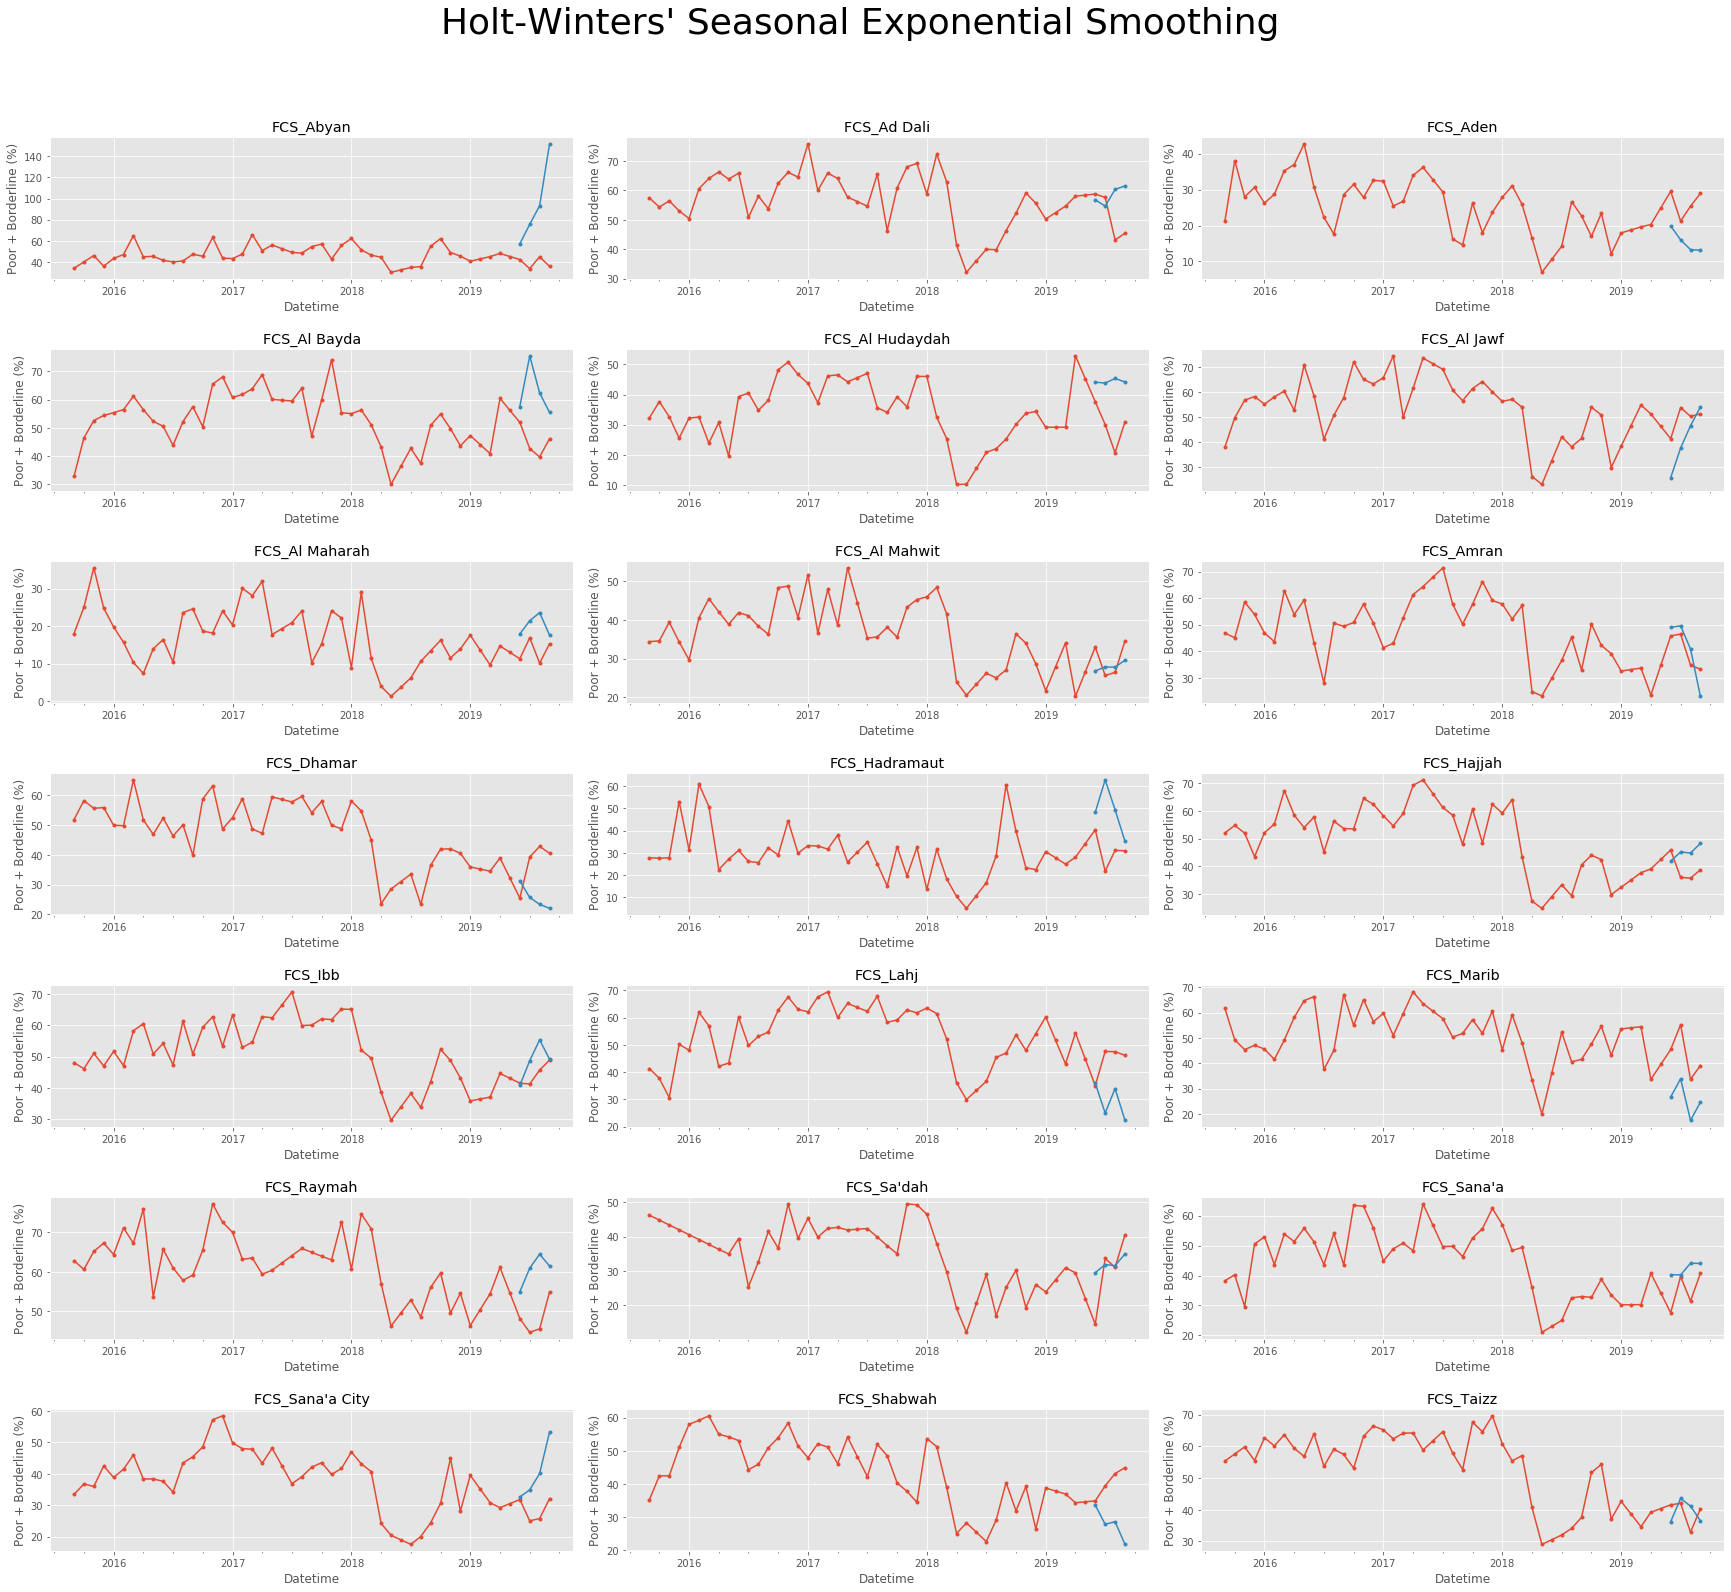

In [43]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Holt-Winters' Seasonal Exponential Smoothing", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [44]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["HW"] = err_test, err_time
df_results["HW"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 375.4792971311976


## 6. Autoregression Forecast

Autoregression is a time-series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. A regression model, such as linear regression, models an output value based on a linear combination of input values (previous time step in our case). Formally, given a time-series $X = \{x_1, x_2, ..., x_m\}$, with $m$ observations, let's suppose to want to predict the next $x_{m + 1}$ value. The regression model predicts that value following a regression equation where input variables are taken from previous time steps, called *lag variables* $p$. For example, we can predict the value for the next time step ($m + 1$) given the observations at the last two time steps ($m - 1$ and $m - 2$). As a regression model, this would look as follows with $p = 2$:

$$\hat{y} = b_0 + b_1 x_{m - 1} + b_2  x_{m}$$

where $\hat{y}$ is the prediction for the $x_{m + 1}$ value, $b_0$, $b_1$ and $b_2$ are coefficients found by optimizing the model on training data. Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

Let's search for the best $p$ parameter of each AdminStrata using a grid search exploiting the **Holdout estimation**.

In [45]:
from statsmodels.tsa.ar_model import AR

In [46]:
# Set the parameter p. All the integer in the range of this number are used during the validation step to establish the best one for each adminstrata.
ps = np.arange(1, len(df_train) + 1, 1)

In [47]:
def evaluate_AR_forecast(time_series, p):
    for i in range(num_val):
        # Make predictions.
        model = AR(time_series)
        model = model.fit(p)
        y_hat = model.predict(start = len(time_series), end = len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [df_val.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate the validation error.
    y_hats = time_series[-num_val:]
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, p

In [48]:
def AR_forecast(time_series, ps):
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_p = float("inf"), None
    for p in ps:
        try:
            error_val, p = evaluate_AR_forecast(time_series, p)
            if error_val < best_score:
                best_score, best_p = error_val, p
        except:
            continue    
        
    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    for i in range(num_test):
        # Make prediction.
        model = AR(time_series)
        model = model.fit(best_p)
        y_hat = model.predict(start = len(time_series), end = len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]            
    
    return (best_p), y_hats

In [49]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(AR_forecast, args = [ps])

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


In [50]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   46.710687    58.630854   8.084354     75.296737        52.211435   
2019-07-31   47.261417    58.440840  18.726303     74.525819        46.548077   
2019-08-31   47.469062    58.019838   3.394750     79.793096        50.086031   
2019-09-30   47.547351    57.698167  17.828044     91.713271        47.080945   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     40.494357       10.921273      28.355828  35.092326   
2019-07-31     38.045189       11.583061      30.713749  34.350920   
2019-08-31     29.898418       13.975711      24.645151  28.951415   
2019-09-30     29.532218       10.255021      23.653671  30.194680   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30    31.796718  ...   43.409390  46.695330  42.862333  39.256376   
2019-07-31    34.161159  ...   44.333412  48.693722  44.507153  34.019783   
2019-08-31    33.488281  ...   45.083394  49.518404  39.278533  39.050831   
2019-09-30    32.332938  ...   45.702326  50.988470  40.866466  48.243413   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    50.827053   25.354663   37.423172        25.569650    33.559573   
2019-07-31    45.625677   26.207268   36.874075        37.637501    35.990545   
2019-08-31    35.899410   27.316366   33.913046        28.715130    29.779362   
2019-09-30    31.551058   28.154669   36.943916        36.434799    33.393518   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   38.612808  
2019-07-31   37.721049  
2019-08-31   39.198526  
2019-09-30   38.751654  

[4 rows x 21 columns]

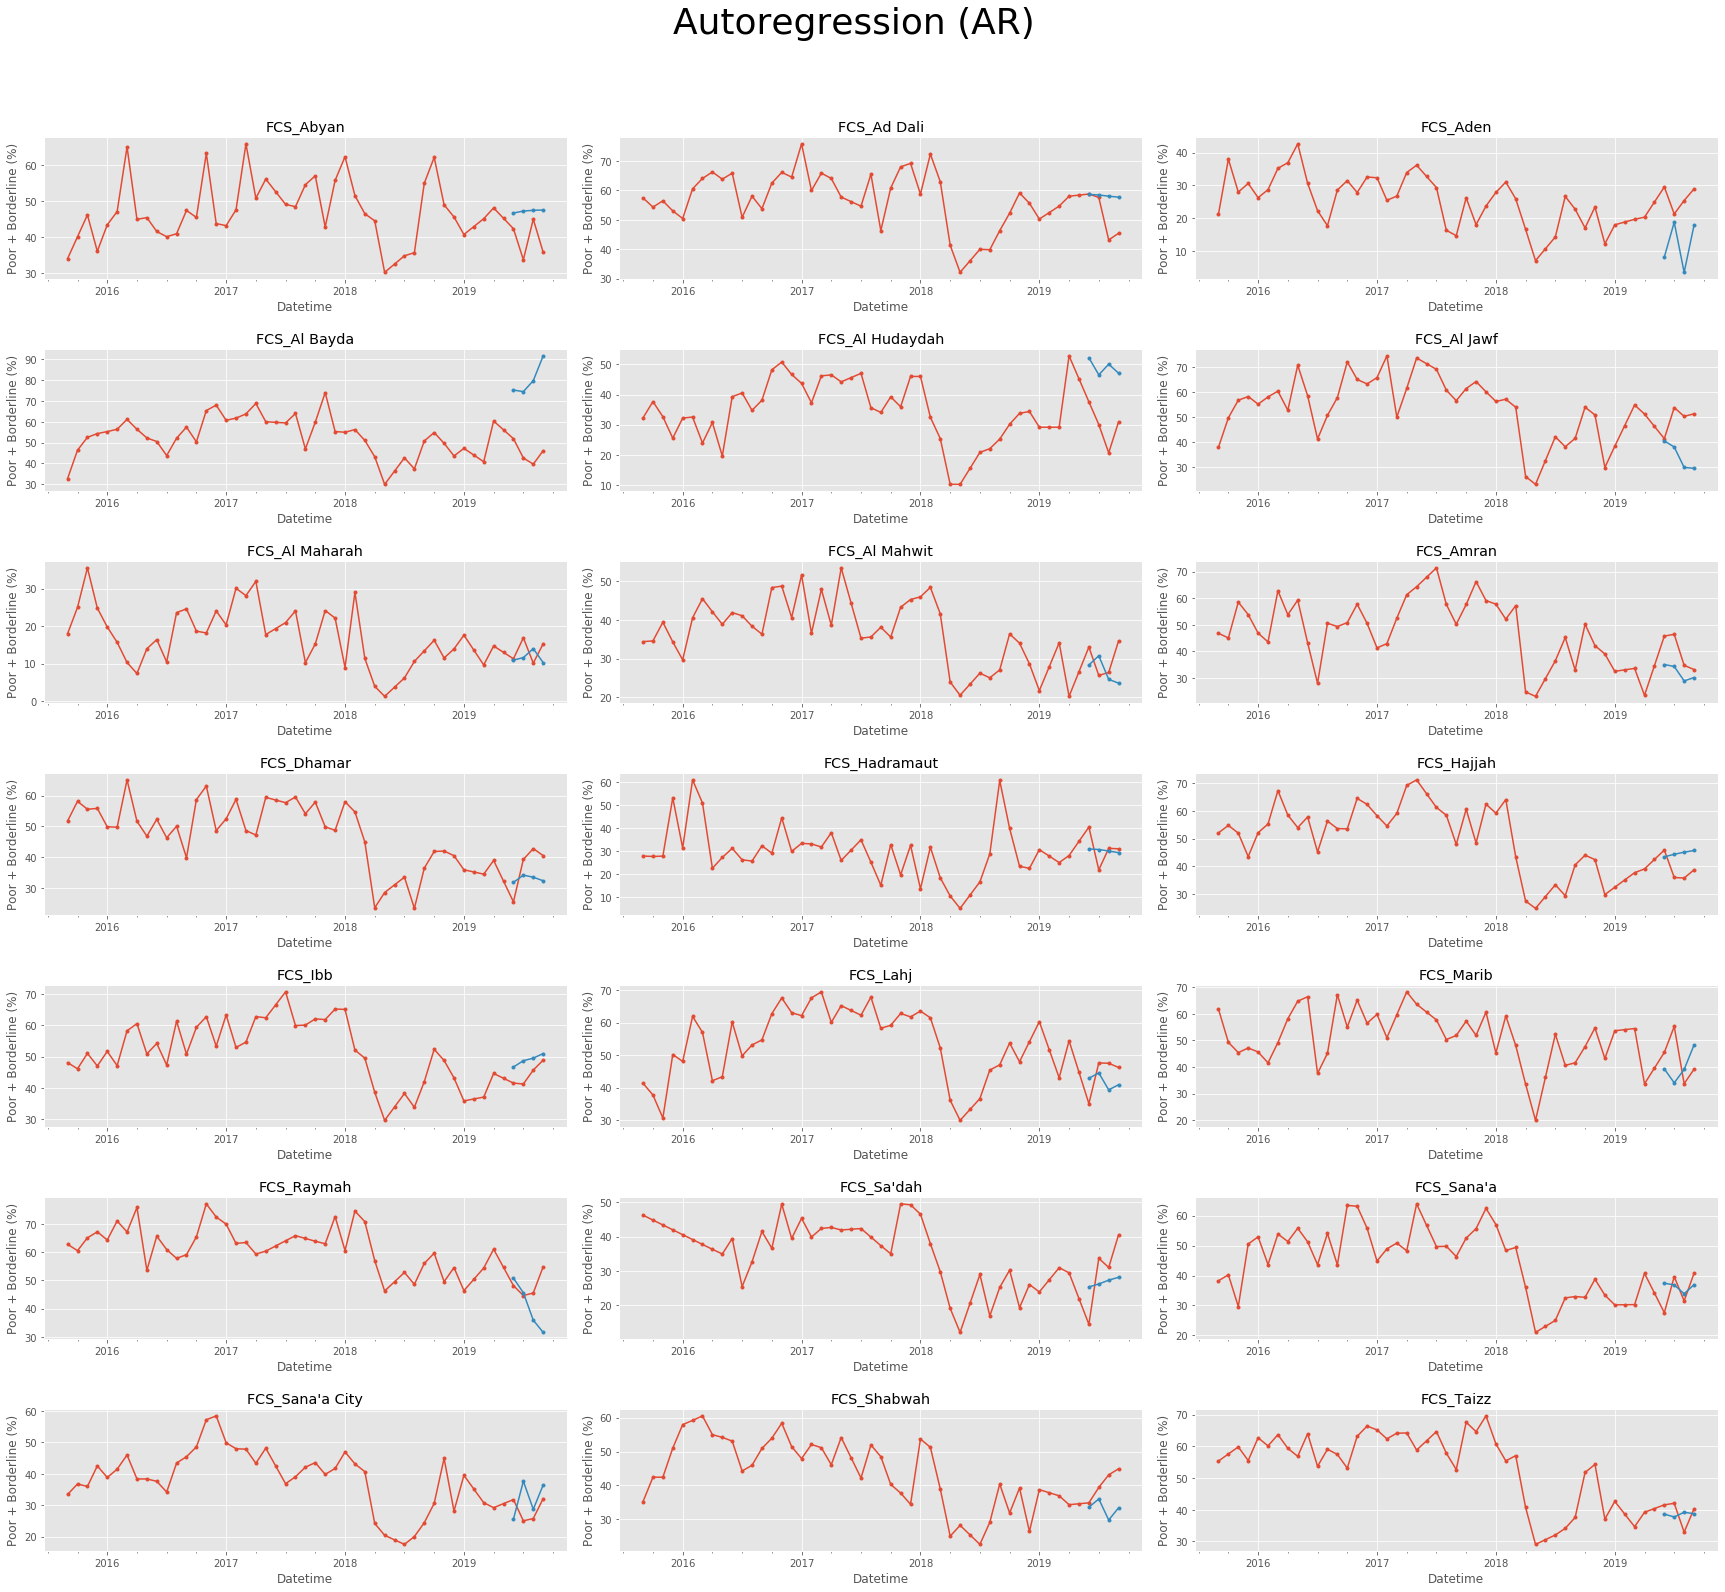

In [51]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Autoregression (AR)", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [52]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["AR"] = err_test, err_time
df_results["AR"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 160.97634066430183


## 7. Moving Average Forecast

The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model $q$ as a parameter to the MA function, e.g. MA($q$). For example, MA(1) is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

Let's search for the best $q$ parameter of each AdminStrata using a grid search exploiting the **Holdout estimation**.

In [53]:
from statsmodels.tsa.arima_model import ARMA

In [58]:
# Set the parameter q. All the integer in the range of this number are used during the validation step to establish the best one for each adminstrata.
qs = np.arange(1, 5 + 1, 1)

In [59]:
def evaluate_MA_forecast(time_series, q):
    for i in range(num_val):
        # Make predictions.
        model = ARMA(time_series, order = (0, q))
        model = model.fit()
        y_hat = model.predict(start = len(time_series), end = len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [df_val.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate the validation error.
    y_hats = time_series[-num_val:]
    error = MSE(y_true = df_val[time_series.name], 
                y_pred = y_hats)
    
    return error, q

In [60]:
def MA_forecast(time_series, qs):
    # Grid search for the best n parameter tested on the validation set.
    best_score, best_q = float("inf"), None
    for q in qs:
        try:
            error_val, q = evaluate_MA_forecast(time_series, q)
            if error_val < best_score:
                best_score, best_q = error_val, q
        except:
            continue    
        
    # Test phase using the test set.
    df = pd.concat([df_train, df_val], axis = 0)
    time_series = df[time_series.name]
    for i in range(num_test):
        # Make prediction.
        model = ARMA(time_series, order = (0, best_q))
        model = model.fit()
        y_hat = model.predict(start = len(time_series), end = len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]            
    
    return (best_q), y_hats

In [61]:
df_train_copy = df_train.copy()

tqdm.pandas()
results = df_train_copy.progress_apply(MA_forecast, args = [qs])


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.15s/it]


In [62]:
df_pred = pd.DataFrame([x[1] for x in results]).transpose()
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   46.272032    57.890094  25.333719     53.490344        39.932654   
2019-07-31   46.813794    57.254413  25.659077     60.745406        33.800380   
2019-08-31   47.033300    56.987890  25.692161     54.120621        34.625594   
2019-09-30   46.691565    56.988477  24.955958     52.741214        34.624400   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     48.400061       12.982197      29.594395  38.845857   
2019-07-31     52.022592       14.401497      32.351547  43.508052   
2019-08-31     53.339347       16.060391      29.053710  44.931349   
2019-09-30     53.338475       16.063232      31.860603  44.704328   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30    36.483782  ...   47.527046  45.061956  46.022130  48.246245   
2019-07-31    37.665862  ...   46.748900  47.275433  53.006363  51.606052   
2019-08-31    42.094324  ...   47.603550  46.502453  53.003283  49.068848   
2019-09-30    42.328218  ...   48.862691  51.065094  53.004901  48.166193   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    59.447093   26.640987   39.246110        36.178040    36.611595   
2019-07-31    60.099310   26.427652   43.335439        38.044557    39.384551   
2019-08-31    59.740703   27.845750   39.992556        38.206271    41.460650   
2019-09-30    58.189420   32.813707   43.529924        38.207805    42.611237   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   47.742570  
2019-07-31   50.597979  
2019-08-31   53.518010  
2019-09-30   53.518711  

[4 rows x 21 columns]

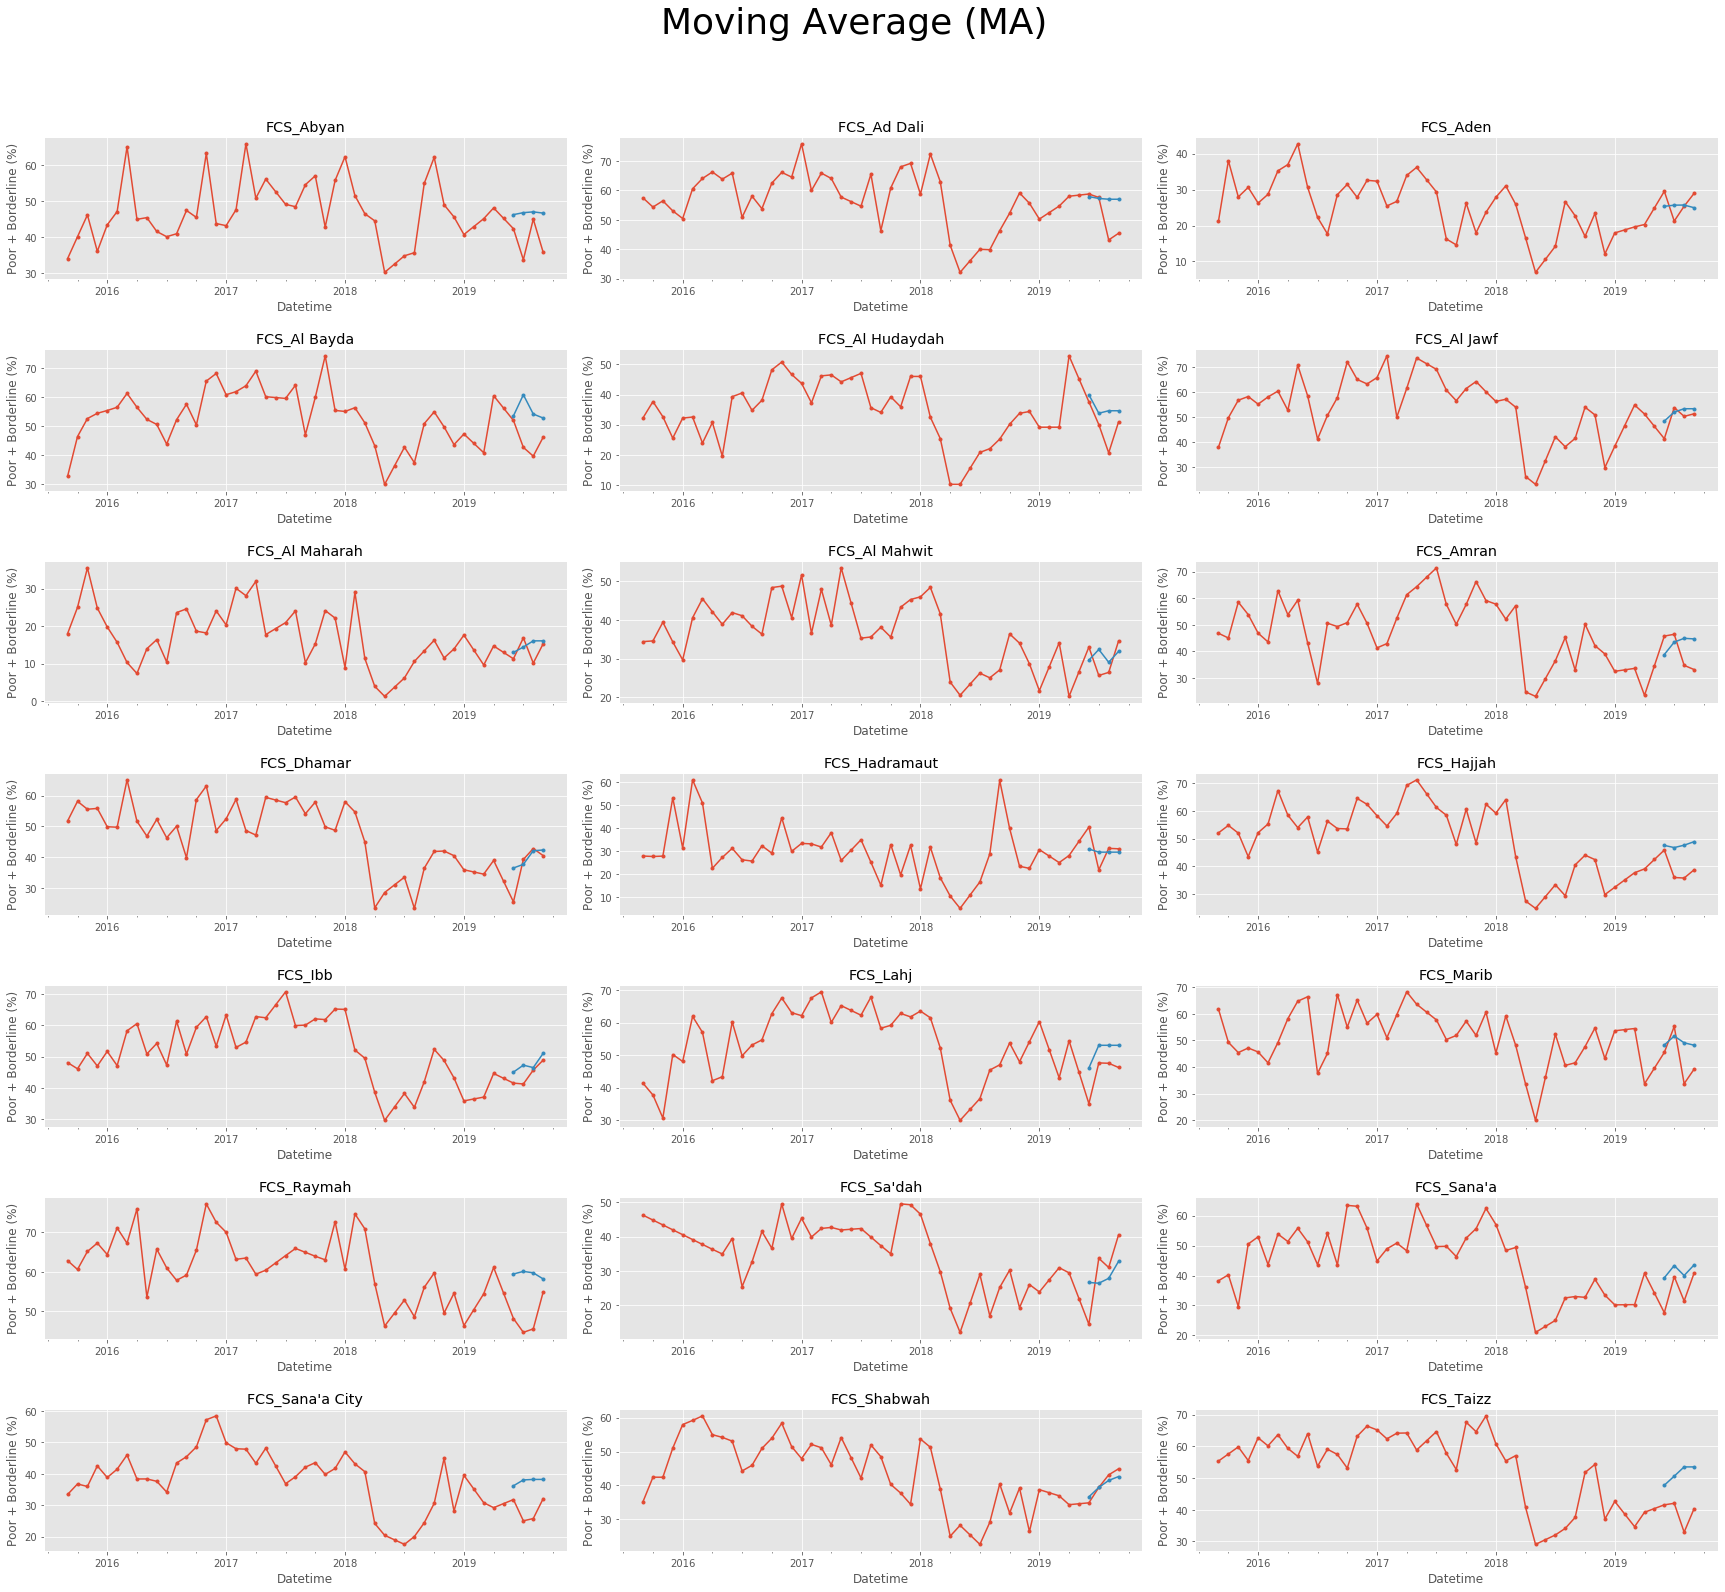

In [63]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("Moving Average (MA)", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [64]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["MA"] = err_test, err_time
df_results["MA"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 64.42209712002216


## 8. Autoregressive Integrated Moving Average Forecast

The Autoregressive Integrated Moving Average (ARIMA) is a class of statistical models for analyzing and forecasting time-series data.

It combines both Autoregression (AR) with p order and Moving Average (MA) with q order models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I) with d order. Autoregression expresses the correlation between observations, i.e. , how much the current values influences the next ones. The integration procedure indicates the number of differences required to guarantee the stationarity of the series. Lastly, the MA part comprises unknown factors that cannot be explained by the time series past values.

The user must specify a tuple of p, d, and q ARIMA parameters. We want to perform a grid search for finding the best setting of these parameters. The statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. 

A problem with ARIMA is that it does not support seasonal data.

Let's search for the best parameters of each AdminStrata using a grid search exploiting the **Box-Jenkins method**.

In [65]:
from pyramid.arima import auto_arima

In [66]:
max_p = 8
max_q = 8

In [67]:
def ARIMA_forecast(time_series, max_p, max_q):
    # Grid search of the p, d, q.
    model = auto_arima(time_series, start_p = 1, start_q = 1,
                       max_p = max_p, max_q = max_q, 
                       seasonal = False, d = None, trace = False,
                       error_action = "ignore", suppress_warnings = True, 
                       n_fits = 30)
    model.fit(time_series)
        
    y_hats = model.predict(n_periods = num_test)
    
    for i in range(num_test):
        y_hat = pd.Series(y_hats[i], index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]  
      
    return y_hats

In [68]:
df_train_copy = pd.concat([df_train, df_val], axis = 0)

tqdm.pandas()
df_pred = df_train_copy.progress_apply(ARIMA_forecast, args = [max_p, max_q])
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.11it/s]


In [69]:
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   46.280393    56.051462  20.752079     54.817770        42.376892   
2019-07-31   46.682053    54.556646  18.772733     53.966252        40.329341   
2019-08-31   46.838625    53.573580  17.736942     53.428048        38.854734   
2019-09-30   46.899659    52.902761  17.112642     53.087876        37.792750   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     48.317354       12.156618      26.616624  35.729414   
2019-07-31     50.153343       11.640328      26.463442  36.237502   
2019-08-31     49.399999       11.271914      26.246083  36.395322   
2019-09-30     48.964555       10.973567      26.002950  36.340266   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30    33.413129  ...   42.247386  43.369223  46.744603  45.430127   
2019-07-31    33.851635  ...   42.029773  43.167086  48.224158  45.203871   
2019-08-31    33.863166  ...   41.812159  43.096937  49.302733  44.945354   
2019-09-30    33.639350  ...   41.594545  42.991334  50.089001  44.686837   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    54.366672   22.633224   35.084500         30.44875    33.926950   
2019-07-31    54.078677   22.899487   35.009243         30.38250    33.363396   
2019-08-31    53.778290   22.904009   34.933986         30.31625    32.854131   
2019-09-30    53.472727   22.740187   34.858728         30.25000    32.379744   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   40.299794  
2019-07-31   40.115606  
2019-08-31   39.850466  
2019-09-30   39.525194  

[4 rows x 21 columns]

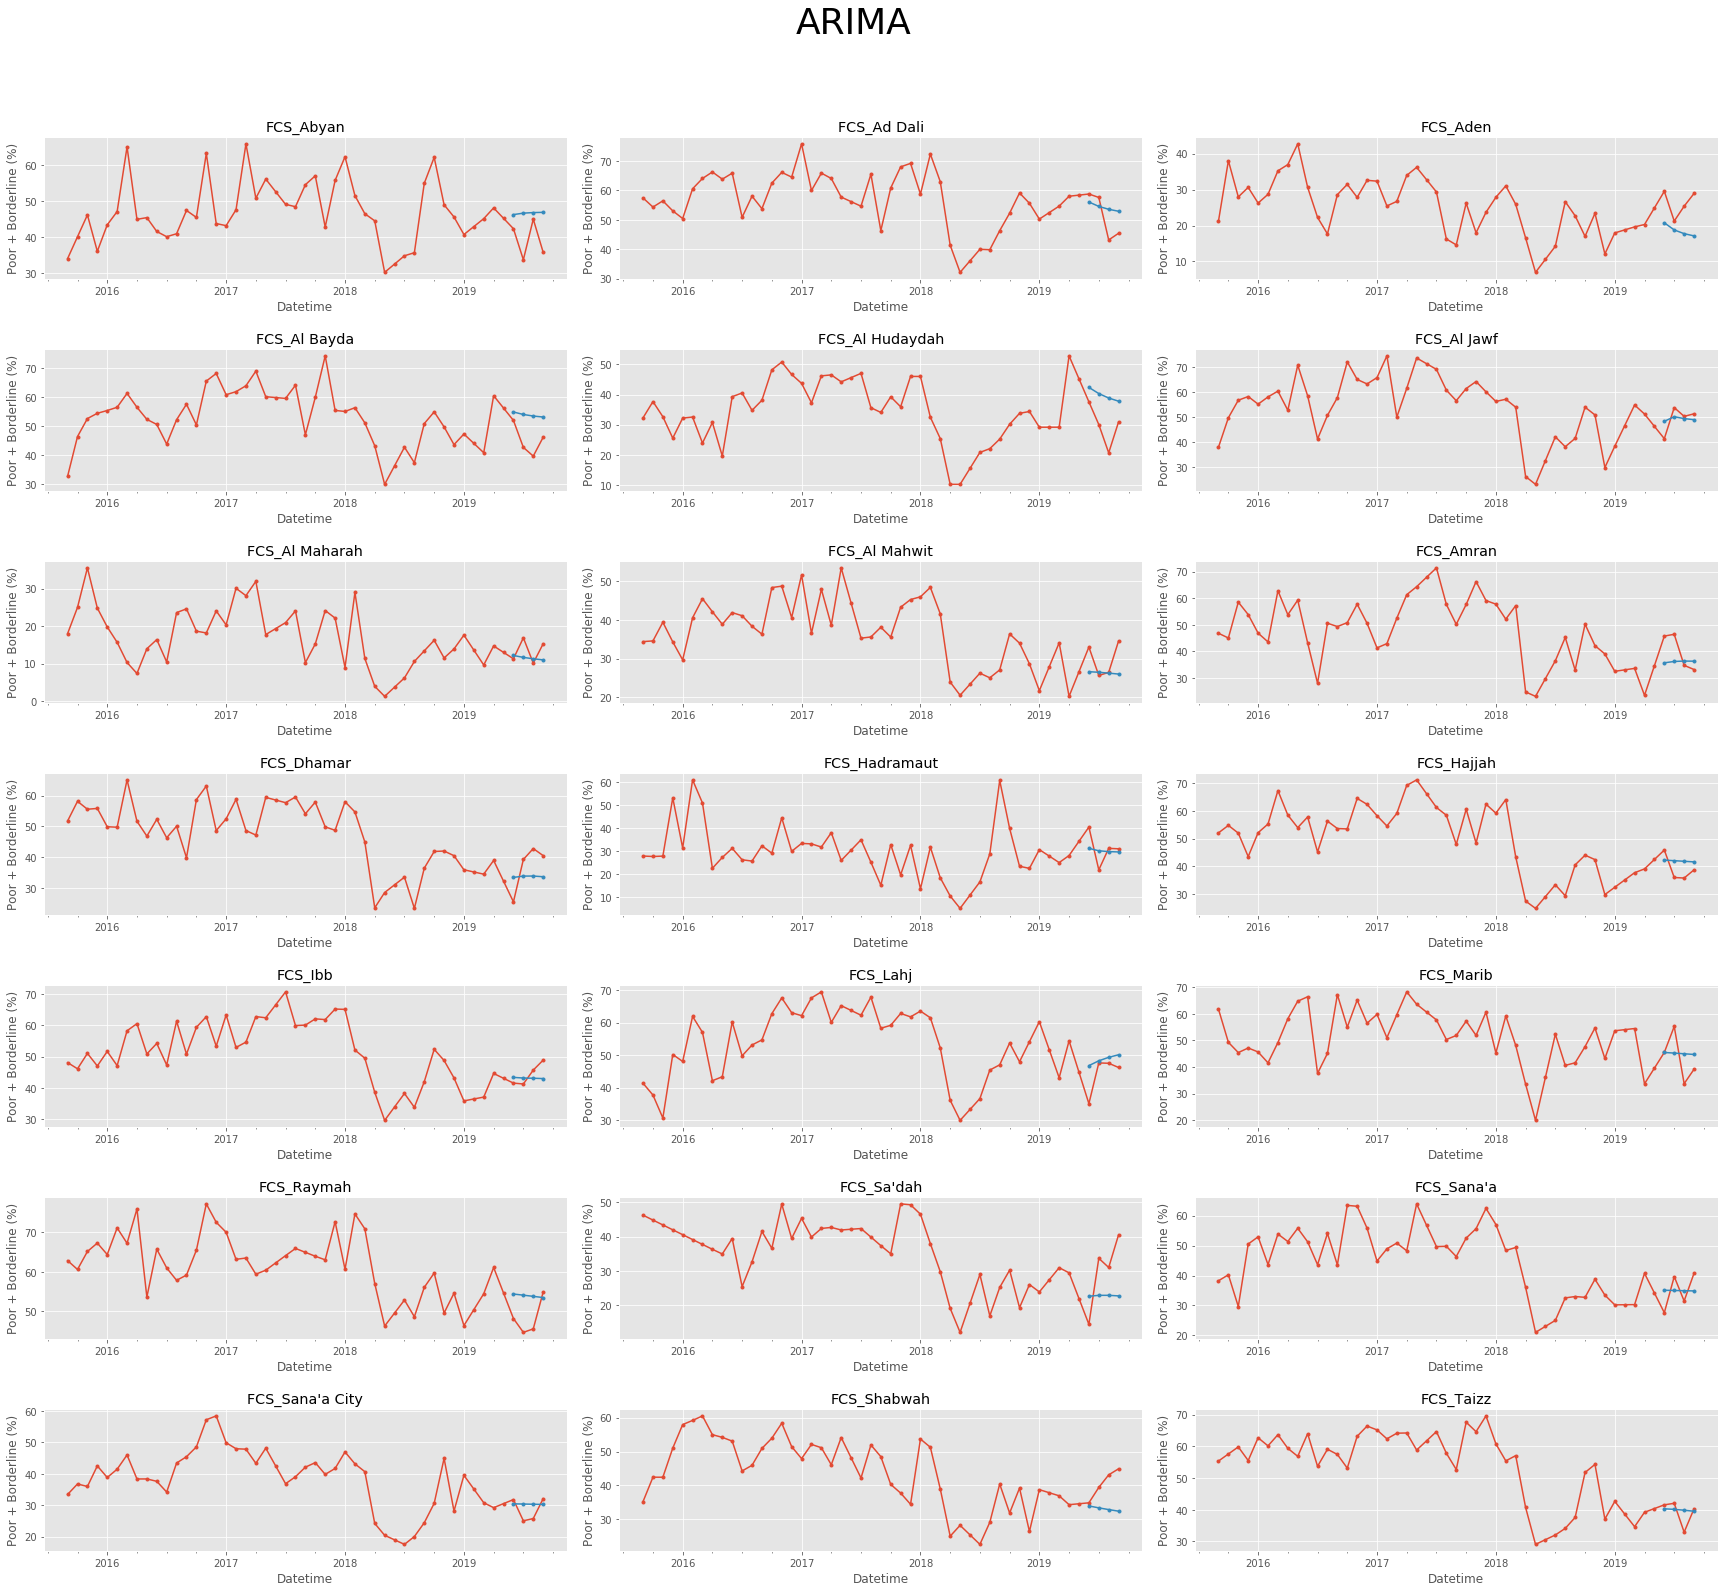

In [70]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("ARIMA", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [71]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["ARIMA"] = err_test, err_time
df_results["ARIMA"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 51.4667683195285


## 9. Seasonal Autoregressive Integrated Moving Average Forecast

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time-series data that may contain trend and seasonal components, unlike the ARIMA model. It is an effective approach for time-series forecasting, although it requires careful analysis and domain expertise in order to configure the seven or more model hyperparameters. There are three trend parameters that require configuration, they are the same as the ARIMA model; specifically p, d and q. There are four seasonal elements that are not part of ARIMA that must be configured; they are: P, D and Q. Together, the notation for a SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q)m. Where the specifically chosen hyperparameters for a model are specified. Importantly, the m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle. 

An alternative approach to configuring the model is to grid search a suite of hyperparameter configurations in order to discover what works best. Let's search for the best parameters of each AdminStrata using a grid search exploiting the **Box-Jenkins method**.

In [72]:
from pyramid.arima import auto_arima

In [73]:
max_p = 8
max_q = 8
max_P = 8
max_Q = 8

In [74]:
def SARIMA_forecast(time_series, max_p, max_q, max_P, max_Q):
    # Grid search of the p, d, q, P, Q, D.
    model = auto_arima(time_series, start_p = 1, start_q = 1,
                       max_p = max_p, max_q = max_q, m = 12,
                       start_P = 0, start_Q = 0, max_P = 8,
                       max_Q = 8, seasonal = True,
                       d = None, D = None, trace = False,
                       error_action = "ignore",  
                       suppress_warnings = True, 
                       n_fits = 30)
    model.fit(time_series)
        
    y_hats = model.predict(n_periods = num_test)
    
    for i in range(num_test):
        y_hat = pd.Series(y_hats[i], index = [df_test.index[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    y_hats = time_series[-num_test:]  
      
    return y_hats

In [75]:
df_train_copy = pd.concat([df_train, df_val], axis = 0)

tqdm.pandas()
df_pred = df_train_copy.progress_apply(SARIMA_forecast, args = [max_p, max_q, max_P, max_Q])
df_pred.columns.name = "AdminStrata"
df_pred.index.name = "Datetime"


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.10it/s]


In [76]:
df_pred

AdminStrata  FCS_Abyan  FCS_Ad Dali   FCS_Aden  FCS_Al Bayda  FCS_Al Hudaydah  \
Datetime                                                                        
2019-06-30   46.280084    56.103104  20.422086     54.817807        42.377078   
2019-07-31   46.681766    54.639768  17.351883     53.966241        40.329612   
2019-08-31   46.838403    53.675893  17.031417     53.427964        38.855031   
2019-09-30   46.899483    53.016775  16.710950     53.087716        37.793042   

AdminStrata  FCS_Al Jawf  FCS_Al Maharah  FCS_Al Mahwit  FCS_Amran  \
Datetime                                                             
2019-06-30     48.317245       12.154248      26.616613  35.843695   
2019-07-31     50.153204       11.636837      26.463432  36.421263   
2019-08-31     49.399923       11.267893      26.246078  36.621329   
2019-09-30     48.964472       10.969293      26.002952  36.591961   

AdminStrata  FCS_Dhamar  ...  FCS_Hajjah    FCS_Ibb   FCS_Lahj  FCS_Marib  \
Datetime                 ...                                                
2019-06-30    33.304485  ...   42.054509  43.369197  46.744172  43.754592   
2019-07-31    33.683109  ...   41.644017  43.167056  48.223510  44.149815   
2019-08-31    33.661637  ...   44.625730  43.096893  49.301999  44.073183   
2019-09-30    33.419631  ...   43.090993  42.991279  50.088255  44.030547   

AdminStrata  FCS_Raymah  FCS_Sa'dah  FCS_Sana'a  FCS_Sana'a City  FCS_Shabwah  \
Datetime                                                                        
2019-06-30    54.308380   22.517430   35.084488         30.44875    33.870057   
2019-07-31    53.995947   22.709241   35.009218         30.38250    33.165114   
2019-08-31    53.685262   22.665901   34.933949         30.31625    34.975671   
2019-09-30    53.375309   22.471321   34.858679         30.25000    38.079065   

AdminStrata  FCS_Taizz  
Datetime                
2019-06-30   40.315604  
2019-07-31   40.143148  
2019-08-31   39.886712  
2019-09-30   39.567895  

[4 rows x 21 columns]

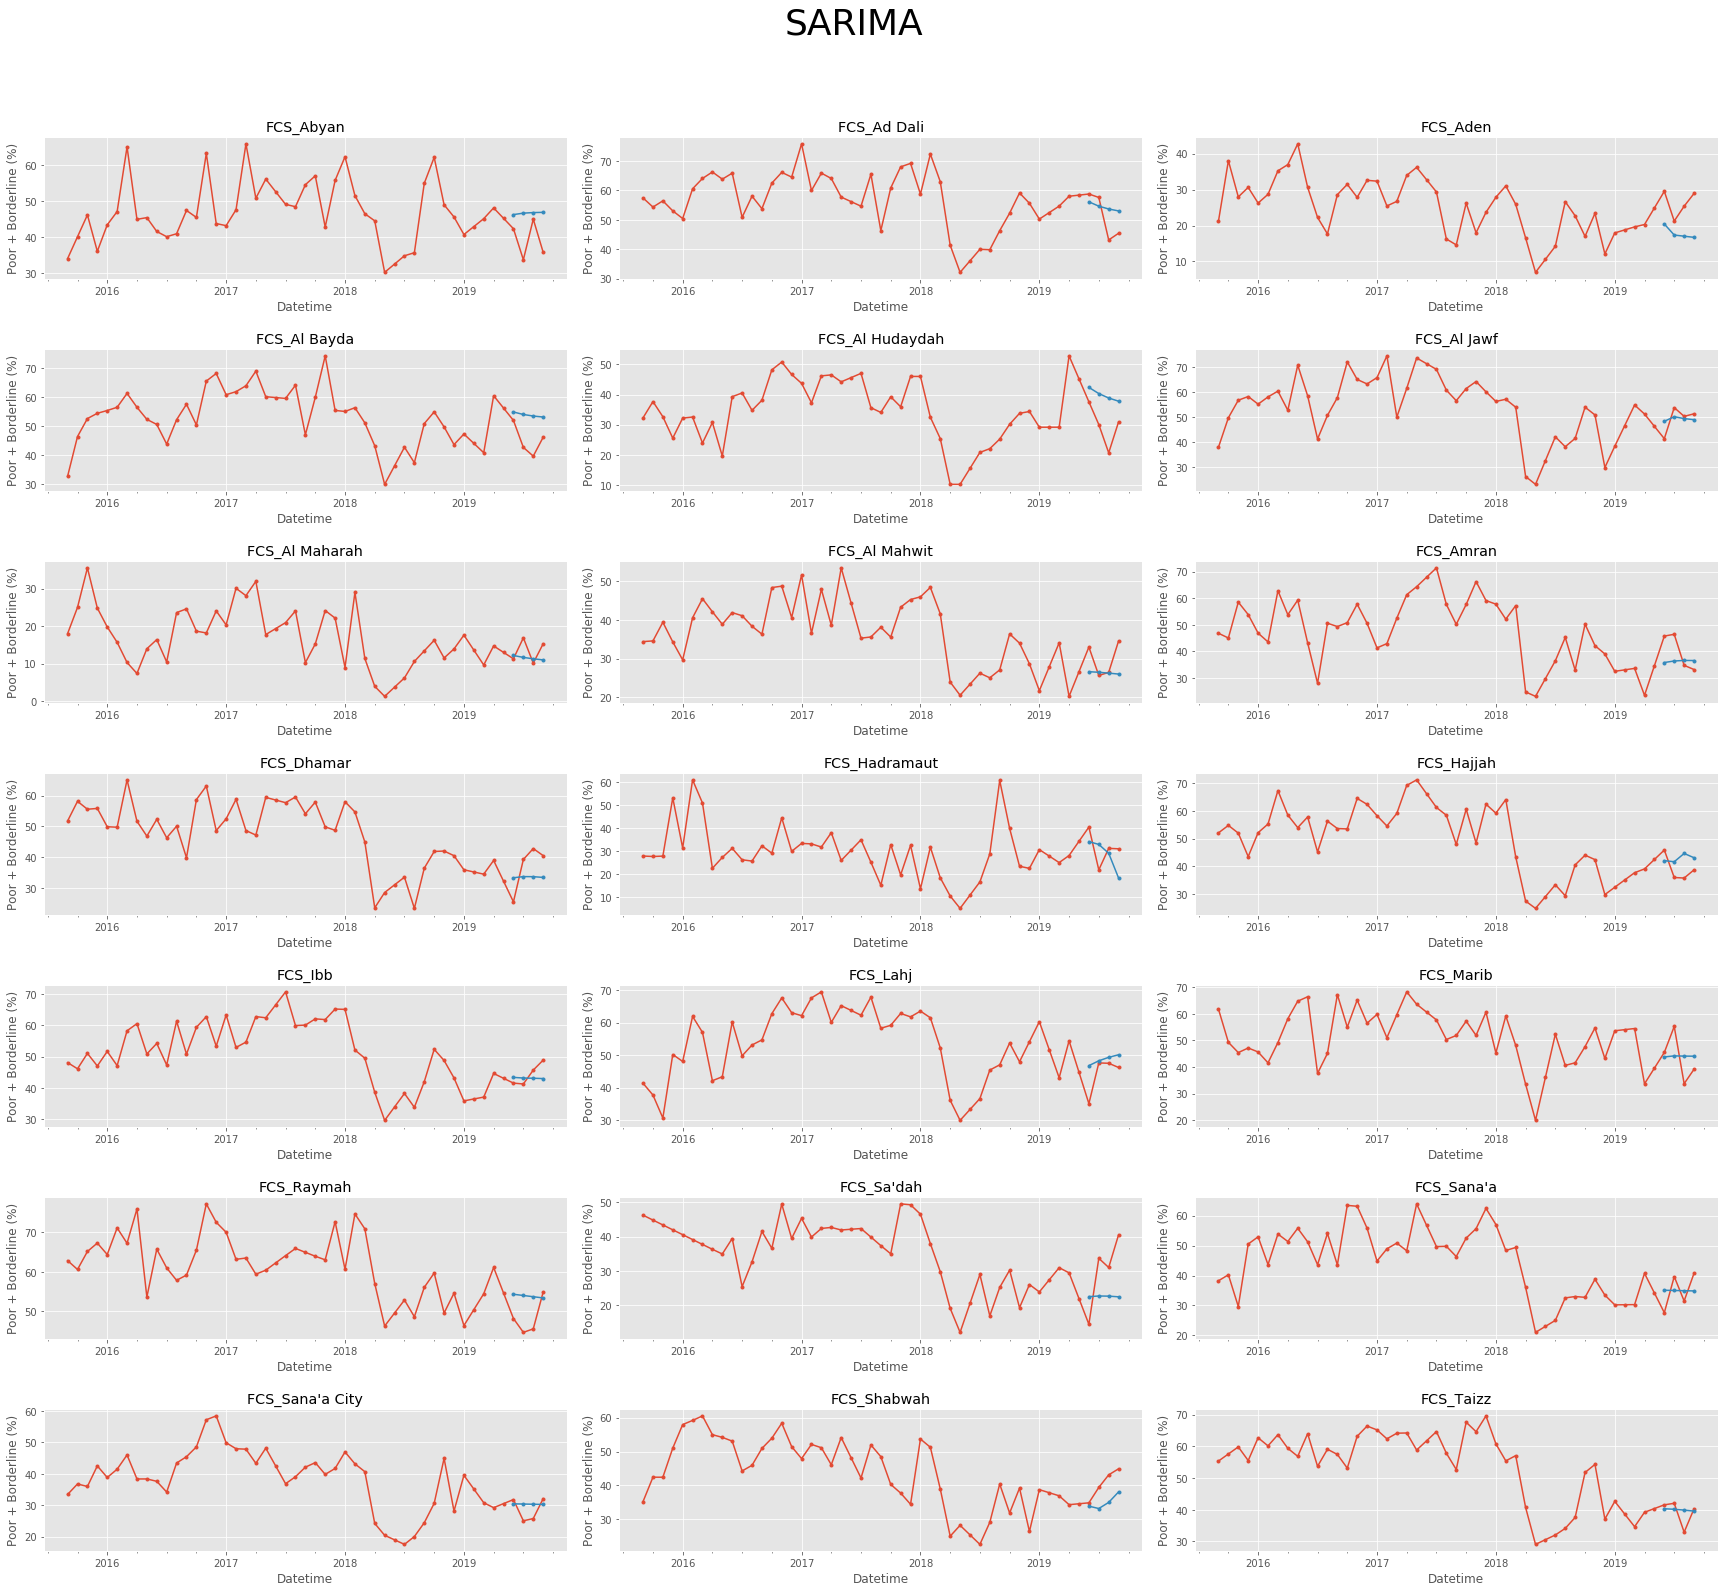

In [77]:
fig, axs = plt.subplots(7, 3, figsize = (30, 26), facecolor = "w", edgecolor = "k")
fig.subplots_adjust(hspace = .5, wspace = .1)
fig.suptitle("SARIMA", fontsize = 36, y = 0.95)

axs = axs.ravel()
    
for i, AdminStrata in enumerate(df_pred.columns):
    axs[i].set_title(AdminStrata, color = "black")
    df[AdminStrata].plot(ax = axs[i], style = ".-")
    df_pred[AdminStrata].plot(ax = axs[i], style = ".-")
    axs[i].set_ylabel("Poor + Borderline (%)")
    axs[i].autoscale()

In [78]:
err_test = MSE(df_test, df_pred, multioutput = "raw_values").mean()
print("MSE:", err_test)

err_time = MSE(df_test.transpose(), df_pred.transpose(), multioutput = "raw_values")

results_forecast["SARIMA"] = err_test, err_time
df_results["SARIMA"] = MSE(df_test, df_pred, multioutput = "raw_values")

MSE: 52.981144280428865


# Results

In [79]:
comparison = dict()
comparison_time = dict()
for item in results_forecast:
    comparison[item] = results_forecast[item][0]
    comparison_time[item] = results_forecast[item][1]

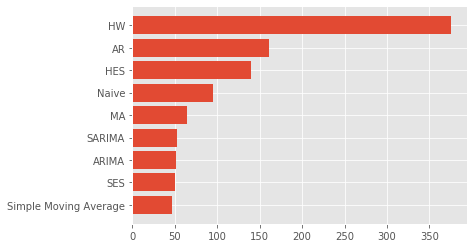

In [80]:
comparison = dict(sorted(comparison.items(), key = lambda x: x[1]))
plt.barh(*zip(*comparison.items()))
plt.show()

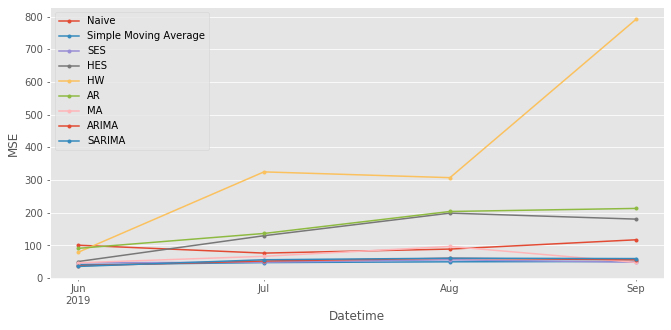

In [81]:
fig, ax = plt.subplots(figsize = (11, 5))
pd.DataFrame(comparison_time, index = df_test.index).plot(ax = fig.gca(), style = ".-")
plt.ylabel("MSE")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

(21.0, 0.0)

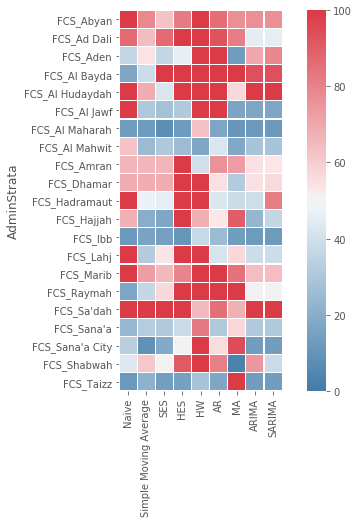

In [82]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(df_results, vmin = 0, vmax = 100, linewidths = .1, cmap = cmap, square = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)